In [ ]:
DATA COLLECTION

In [4]:
# Data Collection - Twitter API - Research Data - Get Tweets
# general
import os
import pandas as pd
import numpy as np
import csv
import string
import random
import itertools
import collections
import time
from collections import Counter

# tweets
import tweepy as tw
import re
from collections import Counter
from string import punctuation
from tweepy import OAuthHandler
import json

# hide warnings
import warnings
warnings.filterwarnings("ignore")

consumer_key= '<REDACTED>'
consumer_secret= '<REDACTED>'
access_token= '<REDACTED>'
access_token_secret= '<REDACTED>'

auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)

# Define the search term and the date_since date as variables
start_time = time.time()

max_id = -1000000000000000000000000000000000
tweetsPerQry = 100  # this is the max the API permits

# Define the search term and the date_since date as variables
corona_terms = "(corona OR covid OR sarscov2 OR covid19 OR coronavirus OR cv19 OR covid-19)"
sturgeon_terms = '("nicola sturgeon" OR "nicolasturgeon" OR "sturgeon")'
boris_terms = '("boris johnson" OR "borisjohnson" or "boris")'
# search_words = corona_terms + " AND " + sturgeon_terms
search_words = corona_terms + " AND " + boris_terms
print("search: " + search_words)
date_since = "2021-04-02"

# open/create a csv file to append data
csvFile = open(search_words + '_data2.csv', 'a', encoding='utf-8')

#Use csv writer
csvWriter = csv.writer(csvFile)

# get data from twitter
tweet_num = 0
for tweet in tw.Cursor(api.search,q=search_words,count=tweetsPerQry,lang="en", 
                       since=date_since, tweet_mode='extended', max_id=str(max_id - 1)).items(9999999999):
    try:
        if 'retweeted_status' in dir(tweet):
            tweet.full_text=tweet.retweeted_status.full_text
        # write data to csv
        csvWriter.writerow([tweet.id_str,
                            tweet.created_at,
                            tweet.full_text
                           ])
        
        tweet_num += 1
        print("tweet number: " + tweet_num)

    except Exception:
        pass

print("--- %s seconds ---" % (time.time() - start_time))
csvFile.close()

search: (corona OR covid OR sarscov2 OR covid19 OR coronavirus OR cv19 OR covid-19) AND ("boris johnson" OR "borisjohnson" or "boris")


TweepError: Failed to send request: HTTPSConnectionPool(host='api.twitter.com', port=443): Read timed out.

In [ ]:
MODEL TRAINING

In [ ]:
BASELINES

In [156]:
# Make Baseline CSV - Sentiment 140 - Training Data - No preprocessing
# general
import os
import pandas as pd
import numpy as np
import csv
import string
import random
import itertools
import collections
import time
from collections import Counter
import json

# hide warnings
import warnings
warnings.filterwarnings("ignore")

# Load train dataset
csv = 'trainingandtestdata/training.1600000.processed.noemoticon.csv'
train  = pd.read_csv(csv, 
                 header=None, 
                 names=['label', 'id', 'date', 'flag', 'user', 'text'],
                 encoding='latin-1')

# Drop unnecesary columns
train.drop(['id','date','flag','user'],axis=1,inplace=True)

#Remove Duplicates and NA
train.drop_duplicates(subset=['text'], inplace=True)
train.dropna(subset=['text'], inplace=True)


# Sample equal positive and negative tweets
sampleneg = train[train.label.isin(['0'])].sample(n = 25000)
samplepos = train[train.label.isin(['4'])].sample(n = 25000)
train = sampleneg.append(samplepos, ignore_index=True)
train.head()

# check the number of positive vs. negative tagged sentences
# 0 — the polarity of the tweet (0 = negative, 4 = positive)
positives = train['label'][train.label == 4]
negatives = train['label'][train.label == 0]

print('number of positve tagged sentences is:  {}'.format(len(positives)))
print('number of negative tagged sentences is: {}'.format(len(negatives)))
print('total length of the data is:            {}'.format(train.shape[0]))
# number of positve tagged sentences is:  25000
# number of negative tagged sentences is: 25000
# total length of the data is:            50000

train.to_csv('trainingandtestdata/train_data_raw_sample.csv', index=False)

number of positve tagged sentences is:  25000
number of negative tagged sentences is: 25000
total length of the data is:            50000


Libraries imported
number of neutral tagged sentences is: 13065
neutral removed
number of positve tagged sentences is:  23602
number of negative tagged sentences is: 13333
total length of the remaining data is: 36935
{'0': {'precision': 0.8090452261306532, 'recall': 0.5731668437832094, 'f1-score': 0.6709793798401392, 'support': 18820}, '1': {'precision': 0.6596474875010593, 'recall': 0.8594534915815623, 'f1-score': 0.746410336313733, 'support': 18115}, 'micro avg': {'precision': 0.7135779071341546, 'recall': 0.7135779071341546, 'f1-score': 0.7135779071341546, 'support': 36935}, 'macro avg': {'precision': 0.7343463568158562, 'recall': 0.7163101676823858, 'f1-score': 0.7086948580769361, 'support': 36935}, 'weighted avg': {'precision': 0.735772177930434, 'recall': 0.7135779071341546, 'f1-score': 0.7079749606312358, 'support': 36935}}


Vader Classifier                              
                     f1-score precision  recall     support
0                      0.6710    0.8090  0.5732  18820.0000
1                      0.7464    0.6596  0.8595  18115.0000
micro avg              0.7136    0.7136  0.7136  36935.0000
macro avg              0.7087    0.7343  0.7163  36935.0000
weighted avg           0.7080    0.7358  0.7136  36935.0000
accuracy               0.7136    0.7136  0.7136      0.7136

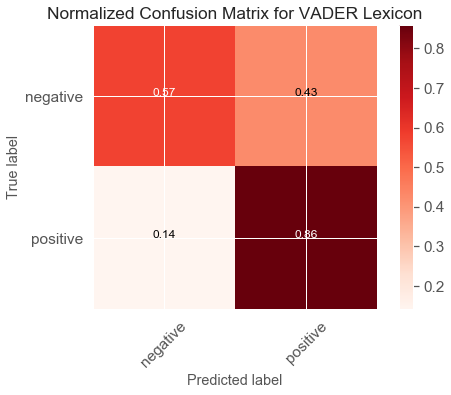

In [119]:
# Baseline Test - VADER Lexicon - Training Data - No cleaning
# general
import os
import pandas as pd
import numpy as np
import csv
import string
import matplotlib.pyplot as plt
import seaborn as sns
import random
import itertools
import collections
from collections import Counter
import json

# Feature Engineering
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# plots
from wordcloud import WordCloud
import plotly
import chart_studio.plotly as py
import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
cf.go_offline()

import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

# hide warnings
import warnings
warnings.filterwarnings("ignore")

print('Libraries imported')
%matplotlib inline

# Load data set
csv = 'trainingandtestdata/train_data_raw_sample.csv'
train = pd.read_csv(csv)

# Apply VADER Lexicon
analyser = SentimentIntensityAnalyzer()

def polarity_scores_all(tweet):
  '''
  Takes string of text to:
  1. Gets sentiment metrics
  2. Returns negative, neutral, positive 
  and compound scores as lists.
  '''
  neg, neu, pos, compound = [], [], [], []
  analyser = SentimentIntensityAnalyzer()
  
  for text in tweet:
    dict_ = analyser.polarity_scores(text)
    neg.append(dict_['neg'])
    neu.append(dict_['neu'])
    pos.append(dict_['pos'])
    compound.append(dict_['compound'])
  
  return neg, neu, pos, compound

all_scores = polarity_scores_all(train.text.values)
train['neg_scores'] = all_scores[0]
train['neu_scores'] = all_scores[1]
train['pos_scores'] = all_scores[2]
train['compound_scores'] = all_scores[3]

# Remove completely neutral scores as no neutrals in labels
neutral = train[train.compound_scores == 0]
print('number of neutral tagged sentences is: {}'.format(len(neutral)))
# number of neutral predicted sentences is: 13065
train = train[train.compound_scores != 0]
print('neutral removed')

# Count remaining results
train.shape
# 36935

# Normalize VADER predictions. Postitive compound score is 1, neg is 0
train.loc[(train['compound_scores'] < 0), 'prediction'] = 0
train.loc[(train['compound_scores'] > 0), 'prediction'] = 1

# check the number of positive, negative VADER predicted sentences
positives = train['prediction'][train.prediction == 1]
negatives = train['prediction'][train.prediction == 0]

print('number of positve tagged sentences is:  {}'.format(len(positives)))
print('number of negative tagged sentences is: {}'.format(len(negatives)))
print('total length of the remaining data is: {}'.format(train.shape[0]))
# number of positve predicted sentences is:  23602
# number of negative predicted sentences is: 13333
# total length of the remaining data is:            36935

# Change labels to 1 is positive and 0 is negative
train['label'] = train['label'].apply(lambda x: 0 if x == 0 else 1)

# Confusion Matrix helper function
plt.style.use(style='ggplot')
plt.rcParams.update({'font.size': 12})

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    

# Compute confusion matrix
cnf_matrix = confusion_matrix(train['label'], train['prediction'])
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
fig = plt.figure(figsize=(20,15))
fig.add_subplot(3,3,1)
plot_confusion_matrix(cnf_matrix, classes=['negative', 'positive'], normalize=True,
                      title='Normalized Confusion Matrix for VADER Lexicon')

# Helper function for Classification Report 

def classification_report_asdf(test, pred, output_dict=True):
  ''' ------------------------------
  Function to return a classification report 
  as dataframe, with rounded scores. 
  --- Parameters:----
  test = test data as array
  pred = prediction data array
  output_dic = set to True
  ------------------------
  '''
  # extract scores as dictionary
  report = classification_report(test,pred, output_dict=output_dict)
  print(report)  
  df_report = pd.DataFrame(report).transpose()
  # round
  df_report[["precision","recall","f1-score"]]= df_report[["precision","recall","f1-score"]].apply(lambda x: round(x,4))
  df_report[["support"]]= df_report[["support"]].apply(lambda x: x.astype(np.int))
  # Add suport to avg
  df_report.loc['accuracy', 'support'] = df_report.loc['weighted avg', 'support']
  df_report.loc['accuracy'] = round(accuracy_score(test, pred),4)

  return df_report

# Classification reports

#--- REPORT VADER ----#
report_vader = classification_report_asdf(train['label'], train['prediction'])

#--- Format Report ----#
dfs = [report_vader]

dfs = pd.concat(
    [df.rename(columns=lambda x: x.zfill(4)) for df in dfs],
    keys=['Vader Classifier'],
    axis=1
)

# Show reports
dfs

In [115]:
# Baseline Test - Supervised Learning - No cleaning or feat eng - Training Data - Model Build
# general
import os
import time
import pandas as pd
import numpy as np
import csv
import string
import matplotlib.pyplot as plt
import seaborn as sns
import random
import itertools
import collections
from collections import Counter
import json
import sys
import argparse
import logging
from logging import critical, error, info, warning, debug

# text manipulation 
import nltk 
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.porter import * 
from nltk.probability import FreqDist

# Feature Engineering
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Machine Learning
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
import pickle

# hide warnings
import warnings
warnings.filterwarnings("ignore")

print('Libraries imported')
%matplotlib inline

# Load data set
csv = 'trainingandtestdata/train_data_raw_sample.csv'
train = pd.read_csv(csv)

# Extracting Features
features = ['text']
label = ['label']

# Saving features and label data in X and y for train-test split
X = train_prep[[col for col in train_prep.columns if col in features]]
y = train_prep[label]

X.shape, y.shape

# # splitting data into training and validation set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

print("Shapes are {} and {}".format(X_train.shape, X_test.shape))

# Where 4 = positive and 0 = negative, Slightly more positive results at baseline
pd.Series(y_train.values.ravel()).value_counts(normalize=True)
pd.Series(y_train.values.ravel()).value_counts(normalize=True)

# Helper functions

class TextSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]    
    
# Pipeline to convert tweets to a matrix of TF-IDF features.
tfidf = Pipeline([
                ('selector', TextSelector(key='text')),
                ('tfidf', TfidfVectorizer())
            ])

# Pipeline to convert tweets to a matrix of token counts
countvect = Pipeline([
                ('selector', TextSelector(key='text')),
                ('countvect', CountVectorizer())
            ])

# defining different sets of text processors
def features_union(textProcessor):
    return FeatureUnion([('text', textProcessor)])

# Normalise labels
le = LabelEncoder().fit(y_train.values.ravel())

y_train = le.transform(y_train.values.ravel())
y_test = le.transform(y_test.values.ravel())

y_train.shape, y_test.shape

#NAIVE BAYES
# instantiate classifier
clf = MultinomialNB()

# combine features
features_count = features_union(countvect)

# define pipeline object 
nb_pipeline = Pipeline([('features', features_count),
                       ('nb', clf)])

# Fit classifier
nb_pipeline.fit(X_train, y_train)

# score
print("nbpipelinescore: " + str(nb_pipeline.score(X_test, y_test)))
# 0.7452361782071927

#SVM
# instantiate classifier
svm = LinearSVC()

#  combine features
features_tfidf = features_union(tfidf)

# define pipeline object
svm_pipeline = Pipeline([('features', features_tfidf),
                       ('svm', svm)])

# Fit classifier
svm_pipeline.fit(X_train, y_train)

# score
print("svmpipelinescore:" + str(svm_pipeline.score(X_test, y_test)))
# 0.7559044551798175

# save each model
pickle.dump(nb_pipeline, open("trainingandtestdata/train_data_raw_model_pipeline_naivebayes.sav", 'wb'))
print('Naive Bayes Classifier saved')
pickle.dump(svm_pipeline, open("trainingandtestdata/train_data_raw_model_pipeline_svm.sav", 'wb'))
print('SVM Classifier saved')

# Naive Bayes
y_preds_nb = nb_pipeline.predict(X_test)
# Save predictions for evaluation as numpy arrays
np.save('trainingandtestdata/train_data_raw_pipeline_y_predsNB.npy', y_preds_nb)

# Support Vector Machine
y_preds_svm = svm_pipeline.predict(X_test)
# Save predictions for evaluation as numpy arrays
np.save('trainingandtestdata/train_data_raw_pipeline_y_predsSVM.npy', y_preds_svm)

# Save test data for evaluation in the next notebook
np.save('trainingandtestdata/train_data_raw_model_y_test.npy', y_test)



Libraries imported
Shapes are (34773, 1) and (14904, 1)
nbpipelinescore: 0.7452361782071927
svmpipelinescore:0.7559044551798175
Naive Bayes Classifier saved
SVM Classifier saved


Libraries imported
Predictions and test data imported
{'0': {'precision': 0.7209773539928487, 'recall': 0.80599600266489, 'f1-score': 0.7611198490091222, 'support': 7505}, '1': {'precision': 0.776481424623887, 'recall': 0.6836058926882012, 'f1-score': 0.7270897721555379, 'support': 7399}, 'micro avg': {'precision': 0.7452361782071927, 'recall': 0.7452361782071927, 'f1-score': 0.7452361782071927, 'support': 14904}, 'macro avg': {'precision': 0.7487293893083679, 'recall': 0.7448009476765456, 'f1-score': 0.74410481058233, 'support': 14904}, 'weighted avg': {'precision': 0.7485320117088345, 'recall': 0.7452361782071927, 'f1-score': 0.7442258246774214, 'support': 14904}}
{'0': {'precision': 0.7558554982135768, 'recall': 0.7610926049300466, 'f1-score': 0.7584650112866816, 'support': 7505}, '1': {'precision': 0.7559548114876821, 'recall': 0.750641978645763, 'f1-score': 0.7532890275328904, 'support': 7399}, 'micro avg': {'precision': 0.7559044551798175, 'recall': 0.7559044551798175, 'f1-score'

Naive Bayes Classifier                                \
                           f1-score precision  recall     support   
0                            0.7611    0.7210  0.8060   7505.0000   
1                            0.7271    0.7765  0.6836   7399.0000   
micro avg                    0.7452    0.7452  0.7452  14904.0000   
macro avg                    0.7441    0.7487  0.7448  14904.0000   
weighted avg                 0.7442    0.7485  0.7452  14904.0000   
accuracy                     0.7452    0.7452  0.7452      0.7452   

             SVM Classifier                                
                   f1-score precision  recall     support  
0                    0.7585    0.7559  0.7611   7505.0000  
1                    0.7533    0.7560  0.7506   7399.0000  
micro avg            0.7559    0.7559  0.7559  14904.0000  
macro avg            0.7559    0.7559  0.7559  14904.0000  
weighted avg         0.7559    0.7559  0.7559  14904.0000  
accuracy             0.7559    0.7559  0.7559      0.7559

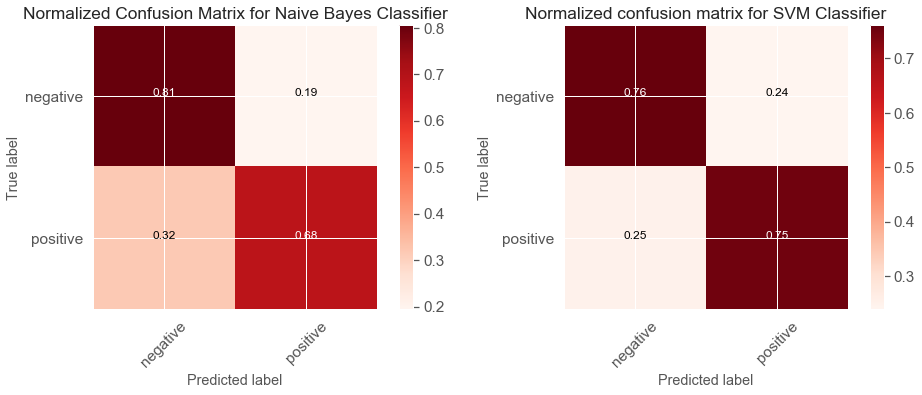

In [116]:
# Baseline Test - Supervised Learning - No cleaning or feat eng - Training Data - Results
# general
import os
import pandas as pd
import numpy as np
import csv
import string
import matplotlib.pyplot as plt
import seaborn as sns
import random
import itertools
import collections
from collections import Counter

# tweets
import tweepy as tw
import re
from collections import Counter
from string import punctuation
from tweepy import OAuthHandler
import json

# text manipulation 
import nltk 
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.porter import * 

# plots
from wordcloud import WordCloud
import plotly
import chart_studio.plotly as py
import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
cf.go_offline()

# Feature Engineering
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Machine Learning
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

# Model Evaluation
from numpy import loadtxt
from keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import itertools

# hide warnings
import warnings
warnings.filterwarnings("ignore")

print('Libraries imported')
%matplotlib inline

# Set up labels
labels = LabelEncoder().fit(['negative', 'positive'])

# Import supervised learning model predictions
y_pred_nb = np.load('trainingandtestdata/train_data_raw_pipeline_y_predsNB.npy')
y_pred_svm = np.load('trainingandtestdata/train_data_raw_pipeline_y_predsSVM.npy')

# Import supervised learning models test data
y_test = np.load('trainingandtestdata/train_data_raw_model_y_test.npy')

print('Predictions and test data imported')

# Confusion Matrix helper function
plt.style.use(style='ggplot')
plt.rcParams.update({'font.size': 12})

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_nb)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
fig = plt.figure(figsize=(20,15))
fig.add_subplot(3,3,1)
plot_confusion_matrix(cnf_matrix, classes=['negative', 'positive'], normalize=True,
                      title='Normalized Confusion Matrix for Naive Bayes Classifier')

#--- Support Vector Machine Classifier ---#

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_svm)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
fig.add_subplot(3,3,2)
plot_confusion_matrix(cnf_matrix, classes=['negative', 'positive'], normalize=True,
                      title='Normalized confusion matrix for SVM Classifier')

# Helper function for Classification Report 

def classification_report_asdf(test, pred, output_dict=True):
  ''' ------------------------------
  Function to return a classification report 
  as dataframe, with rounded scores. 
  --- Parameters:----
  test = test data as array
  pred = prediction data array
  output_dic = set to True
  ------------------------
  '''
  # extract scores as dictionary
  report = classification_report(test,pred, output_dict=output_dict)
  print(report)  
  df_report = pd.DataFrame(report).transpose()
  #round
  df_report[["precision","recall","f1-score"]]= df_report[["precision","recall","f1-score"]].apply(lambda x: round(x,4))
  df_report[["support"]]= df_report[["support"]].apply(lambda x: x.astype(np.int))
  # Add suport to avg
  df_report.loc['accuracy', 'support'] = df_report.loc['weighted avg', 'support']
  df_report.loc['accuracy'] = round(accuracy_score(test, pred),4)

  return df_report

# Classification reports for Supervised ML models

#--- Naive Bayes Classifier ----#
report_nb = classification_report_asdf(y_test, y_pred_nb)

#--- SVM Classifier ----#
report_svm = classification_report_asdf(y_test, y_pred_svm)

#--- Add reports together ----#
SML_dfs = [report_nb, report_svm]

SML_dfs_combined = pd.concat(
    [df.rename(columns=lambda x: x.zfill(4)) for df in SML_dfs],
    keys=['Naive Bayes Classifier', 'SVM Classifier'],
    axis=1
)

# Show reports
SML_dfs_combined

Libraries imported
{'i': 1, 'to': 2, 'the': 3, 'a': 4, 'my': 5, 'and': 6, 'you': 7, 'is': 8, 'it': 9, 'for': 10, 'in': 11, 'of': 12, 'me': 13, 'on': 14, 'so': 15, 'have': 16, 'that': 17, 'but': 18, "i'm": 19, 'just': 20, 'with': 21, 'be': 22, 'at': 23, 'not': 24, 'was': 25, 'this': 26, 'now': 27, 'good': 28, 'up': 29, 'day': 30, 'get': 31, 'out': 32, 'all': 33, 'like': 34, 'are': 35, 'no': 36, 'go': 37, 'http': 38, 'quot': 39, 'do': 40, 'today': 41, 'going': 42, "it's": 43, 'your': 44, 'too': 45, 'work': 46, 'love': 47, 'got': 48, 'back': 49, 'lol': 50, 'time': 51, 'we': 52, 'from': 53, 'com': 54, 'u': 55, 'im': 56, 'what': 57, 'about': 58, 'one': 59, 'really': 60, 'will': 61, 'know': 62, 'had': 63, "don't": 64, 'am': 65, 'can': 66, 'some': 67, 'see': 68, "can't": 69, 'amp': 70, 'still': 71, 'if': 72, 'its': 73, 'want': 74, 'think': 75, '2': 76, 'oh': 77, 'well': 78, 'new': 79, 'thanks': 80, 'home': 81, 'how': 82, 'there': 83, 'when': 84, 'night': 85, 'more': 86, 'here': 87, 'off': 88,

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
			Feature Shapes:
Train set X: 		(35000, 39) 
Train set Y: 		(35000, 2) 
Test set X: 		(15000, 39) 
Test set Y: 		(15000, 2)
Building model...
Model: "LSTMModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 39, 128)           1280000   
_________________________________________________________________
dropout_2 (Dropout)          (None, 39, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 200)               263200    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 402       
Total params

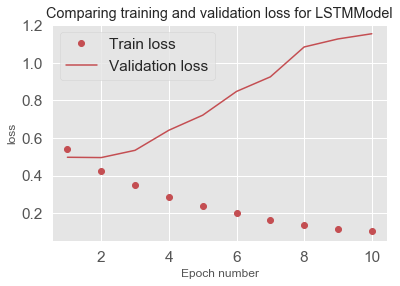

Minimum validation loss reached in epoch 2
start fit
1094/1094 [==============================] - 184s 168ms/step - loss: 0.2996 - accuracy: 0.8909
start eval
469/469 [==============================] - 13s 27ms/step - loss: 0.6068 - accuracy: 0.7437

Test accuracy: 74.37%
Saved LSTM model to drive
LSTM model predictions saved to drive


In [127]:
# Baseline Test - LTSM - Training Data - No cleaning
# general
import os
import time
import pandas as pd
import numpy as np
import csv
import string
import matplotlib.pyplot as plt
import seaborn as sns
import random
import itertools
import collections
from collections import Counter

# tweets
import tweepy as tw
import re
from collections import Counter
from string import punctuation
from tweepy import OAuthHandler
import json

# text manipulation 
import nltk 
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.porter import * 

# plots
from wordcloud import WordCloud
import plotly
import chart_studio.plotly as py
import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
cf.go_offline()

# Feature Engineering
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Machine Learning
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

# Deep Learning
import torch
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras import regularizers
from keras.layers import Dense, Embedding, LSTM, Dropout

# hide warnings
import warnings
warnings.filterwarnings("ignore")

# set plot preferences
plt.style.use(style='ggplot')
plt.rcParams['figure.figsize'] = (10, 6)
pd.set_option("display.max_colwidth", 200) 

print('Libraries imported')
%matplotlib inline

# Load back in
train_prep = pd.read_csv('trainingandtestdata/train_data_raw_sample.csv')

# Double checking for missing values
train_prep.isnull().values.any()

# Parameter indicating the number of words
nb_words = 10000  

## create the tokenizer (tweets have been preprocessed so no need for filters)
tk = Tokenizer(num_words=nb_words)

# fit the tokenizer on tweets
tk.fit_on_texts(train_prep.text)

# integer encode tweets
tweets_seq = tk.texts_to_sequences(train_prep.text)

print(tk.word_index)
print()
print(tweets_seq)

# stats about vocabulary
print('Unique words: ', len((tweets_seq)))
print()

# print first encoded tweet
print('Encoded tweet: \n', tweets_seq[:1])

# Maximum length since maximum tweet word count is 39.
max_len = 39

# Convert sequences into 2-D Numpy arrays
features = pad_sequences(tweets_seq, maxlen=max_len)

# test statements 
assert len(features)==len(tweets_seq), "The features should have as many rows as tweets."
assert len(features[0])==max_len, "Each feature row should contain the mex length of values."

# print first 10 values of the first 30 batches 
print(features[:10,:10])

# to hot-encode
train_prep["label"] = train_prep["label"].astype("category")
train_prep.label.describe()

## split data into training and test data (features and labels, x and y)
# data needs to be as array
labels = pd.get_dummies(train_prep['label']).values
# labels = np.asarray(train_prep.label.values)

X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size = 0.3, random_state = 42)

## print out the shapes of the resultant feature data
print("\t\t\tFeature Shapes:")
print("Train set X: \t\t{}".format(X_train.shape),
      "\nTrain set Y: \t\t{}".format(Y_train.shape),
      "\nTest set X: \t\t{}".format(X_test.shape),
      "\nTest set Y: \t\t{}".format(Y_test.shape))
    
#--- Parameters----#

# encodes input sequence dense vectors 
embed_dim = 128

# transforms the vector sequence into a single vector
lstm_out = 200

# epochs
epochs = 10

#------# Build the LSTM model #-----------------#

print('Building model...') 

# Initialising the RNN
model = Sequential()

#adding an input layer and the first hidden layer
model.add(Embedding(10000, embed_dim, 
                    input_length = features.shape[1]
                   )) 
model.add(Dropout(0.2))
# Adding the second hidden layer
model.add(LSTM(lstm_out, recurrent_dropout = 0.2, dropout = 0.2))
# Adding the output layer
model.add(Dense(2, activation='softmax'))

# Compile model
model.compile( optimizer='adam', # optimizer
              loss = 'categorical_crossentropy', # loss function
              metrics = ['accuracy']) # list of metrics

model._name = 'LSTMModel'
print(model.summary())

# Fit the model
history = model.fit(x=X_train, y=Y_train, 
                    validation_split=0.30,
                    epochs = epochs, verbose = 1)

# Helper functions

def eval_metric(model, history, metric_name):
    '''
    Function to evaluate a trained model on a chosen metric. 
    Training and validation metric are plotted in a
    line chart for each epoch.
    
    Parameters:
        history : model training history
        metric_name : loss or accuracy
    Output:
        line chart with epochs of x-axis and metric on
        y-axis
    '''
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, epochs + 1)

    plt.plot(e, metric, 'ro', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'r', label='Validation ' + metric_name)
    plt.xlabel('Epoch number')
    plt.ylabel(metric_name)
    plt.title('Comparing training and validation ' + metric_name + ' for ' + model.name)
    plt.legend()
    plt.show()


def optimal_epoch(model_hist):
    '''
    Function to return the epoch number where the validation loss is
    at its minimum
    
    Parameters:
        model_hist : training history of model
    Output:
        epoch number with minimum validation loss
    '''
    min_epoch = np.argmin(model_hist.history['val_loss']) + 1
    print("Minimum validation loss reached in epoch {}".format(min_epoch))
    return min_epoch

def test_model(model, X_train, y_train, X_test, y_test, epoch_stop):
    '''
    Function to test the model on new data after training it
    on the full training data with the optimal number of epochs.
    
    Parameters:
        model : trained model
        X_train : training features
        y_train : training target
        X_test : test features
        y_test : test target
        epochs : optimal number of epochs
    Output:
        test accuracy and test loss
    '''
    print('start fit')
    model.fit(X_train
              , y_train
              , epochs=epoch_stop
              , verbose=1)
    print('start eval')
    results = model.evaluate(X_test, y_test)
    print()
    print('Test accuracy: {0:.2f}%'.format(results[1]*100))
    return results

eval_metric(model, history, 'loss')
optimal_epoch(history)

base_min = 1 # first model
# Training on the full train data and evaluation on test data on first model
base_results = test_model(model, X_train, Y_train, X_test, Y_test, base_min)

# save first model and architecture
model.save('trainingandtestdata/train_data_raw_LSTM_model.h5')
print('Saved LSTM model to drive')

# saving predictions
X_train, X_test, Y_train, Y_test

#-- LSTM model ----#
y_preds_LSTM = model.predict(X_test)

# Save predictions for evaluation as numpy arrays
np.save('trainingandtestdata/train_data_raw_y_predsLSTM.npy', y_preds_LSTM)
print('LSTM model predictions saved to drive')

# Save test data
np.save('trainingandtestdata/train_data_raw_y_testLSTM.npy', Y_test)

Libraries imported
Predictions and test data imported
{'0': {'precision': 0.7495932754880694, 'recall': 0.7346532022322615, 'f1-score': 0.7420480472419809, 'support': 7526}, '1': {'precision': 0.7380640083945436, 'recall': 0.7528766390152529, 'f1-score': 0.745396741290237, 'support': 7474}, 'micro avg': {'precision': 0.7437333333333334, 'recall': 0.7437333333333334, 'f1-score': 0.7437333333333334, 'support': 15000}, 'macro avg': {'precision': 0.7438286419413065, 'recall': 0.7437649206237572, 'f1-score': 0.743722394266109, 'support': 15000}, 'weighted avg': {'precision': 0.7438486260042686, 'recall': 0.7437333333333334, 'f1-score': 0.743716589863092, 'support': 15000}}


LSTM Classifier                              
                    f1-score precision  recall     support
0                     0.7420    0.7496  0.7347   7526.0000
1                     0.7454    0.7381  0.7529   7474.0000
micro avg             0.7437    0.7437  0.7437  15000.0000
macro avg             0.7437    0.7438  0.7438  15000.0000
weighted avg          0.7437    0.7438  0.7437  15000.0000
accuracy              0.7437    0.7437  0.7437      0.7437

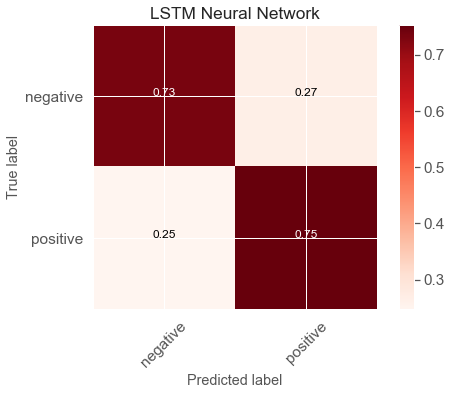

In [128]:
# Baseline Test - LTSM - No Cleaning - Training Data - Results
# general
import os
import pandas as pd
import numpy as np
import csv
import string
import matplotlib.pyplot as plt
import seaborn as sns
import random
import itertools
import collections
from collections import Counter

# tweets
import tweepy as tw
import re
from collections import Counter
from string import punctuation
from tweepy import OAuthHandler
import json

# text manipulation 
import nltk 
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.porter import * 

# plots
from wordcloud import WordCloud
import plotly
import chart_studio.plotly as py
import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
cf.go_offline()

# Feature Engineering
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Machine Learning
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

# Model Evaluation
from numpy import loadtxt
from keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import itertools

# set plot preferences
plt.style.use(style='ggplot')
plt.rcParams['figure.figsize'] = (10, 6)
pd.set_option("display.max_colwidth", 200) 

# hide warnings
import warnings
warnings.filterwarnings("ignore")

print('Libraries imported')
%matplotlib inline

# Set up labels
labels = LabelEncoder().fit(['negative', 'positive'])

# Import deep learning predictions
y_preds_LSTM = np.load('trainingandtestdata/train_data_raw_y_predsLSTM.npy')

# To output vector of labels for confusion matrix
y_preds_LSTM = np.argmax(y_preds_LSTM, axis=1)

# Import deep learning test data
Y_test = np.load('trainingandtestdata/train_data_raw_y_testLSTM.npy')
Y_test = np.argmax(Y_test, axis = 1)


print('Predictions and test data imported')

# Confusion Matrix helper function
plt.style.use(style='ggplot')
plt.rcParams.update({'font.size': 12})

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
#--- LSTM Recurrent Neural Network ---#

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test, y_preds_LSTM)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
fig = plt.figure(figsize=(20,15))
fig.add_subplot(3,3,1)
plot_confusion_matrix(cnf_matrix, classes=['negative', 'positive'], normalize=True,
                      title='LSTM Neural Network')

# Helper function for Classification Report 

def classification_report_asdf(test, pred, output_dict=True):
  ''' ------------------------------
  Function to return a classification report 
  as dataframe, with rounded scores. 
  --- Parameters:----
  test = test data as array
  pred = prediction data array
  output_dic = set to True
  ------------------------
  '''
  # extract scores as dictionary
  report = classification_report(test,pred, output_dict=output_dict)
  print(report)  
  df_report = pd.DataFrame(report).transpose()
  #round
  df_report[["precision","recall","f1-score"]]= df_report[["precision","recall","f1-score"]].apply(lambda x: round(x,4))
  df_report[["support"]]= df_report[["support"]].apply(lambda x: x.astype(np.int))
  # Add suport to avg
  df_report.loc['accuracy', 'support'] = df_report.loc['weighted avg', 'support']
  df_report.loc['accuracy'] = round(accuracy_score(test, pred),4)

  return df_report

# Classification report for RNN models

#---- LSTM Network ----#
report_LSTM = classification_report_asdf(Y_test, y_preds_LSTM)

#--- Add reports together ----#
SML_dfs = [report_LSTM]

SML_dfs_combined = pd.concat(
    [df.rename(columns=lambda x: x.zfill(4)) for df in SML_dfs],
    keys=['LSTM Classifier'],
    axis=1
)

# Show reports
SML_dfs_combined


In [ ]:
FEATURE ENGINEERING AND CLEANING

In [123]:
# Make CSV - Data Cleaning and Feature Adding - Training Data
# general
import os
import pandas as pd
import numpy as np
import csv
import string
import matplotlib.pyplot as plt
import seaborn as sns
import random
import itertools
import collections
import time
from collections import Counter
import json

# text manipulation 
import nltk 
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.porter import * 

# Feature Engineering
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# hide warnings
import warnings
warnings.filterwarnings("ignore")

# Pipeline like preprocessing with helper functions

nltk.download('stopwords')
stop_words = stopwords.words('english')

# cleaning helper function
def processTweet(tweet):
    """
    Takes in a string of text, then performs the following:
    1. Removes links, special characters and other bulk cleaning
    2. Returns a list of the tidy text
    """
    # Remove HTML special entities (e.g. &amp;)
    tweet = re.sub(r'\&\w*;', '', tweet)
    #Convert @username to AT_USER
    tweet = re.sub('@[^\s]+','',tweet)
    # Remove tickers
    tweet = re.sub(r'\$\w*', '', tweet)
    # To lowercase
    tweet = tweet.lower()
    # Remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)
    # Remove hashtags
    tweet = re.sub(r'#\w*', '', tweet)
    # Remove words with 2 or fewer letters
    tweet = re.sub(r'\b\w{1,2}\b', '', tweet)
    # Remove whitespace (including new line characters)
    tweet = re.sub(r'\s\s+', ' ', tweet)
    # Remove single space remaining at the front of the tweet.
    tweet = tweet.lstrip(' ') 
    # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
    tweet = ''.join(c for c in tweet if c <= '\uFFFF') 
    return tweet

# tokenize helper function
def text_process(tweet):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in list(tweet) if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.lower().split() if word.lower() not in stopwords.words('english')]

# Lexicon normalisation with Stemming 
def stemming(tokens):
  """
  Takes in a string of text, then performs the following:
  1. Replace words for its root based on orter Stemmer rule.
  2. Returns normalised text
   """
  stemmer = PorterStemmer()
  x = [stemmer.stem(w) for w in tokens]
   
  return ' '.join(x)

# Adding VADER Lexicon
analyser = SentimentIntensityAnalyzer()
def polarity_scores_all(tweet):
  '''
  Takes string of text to:
  1. Gets sentiment metrics
  2. Returns negative, neutral, positive 
  and compound scores as lists.
  '''
  neg, neu, pos, compound = [], [], [], []
  analyser = SentimentIntensityAnalyzer()
  
  for text in tweet:
    dict_ = analyser.polarity_scores(text)
    neg.append(dict_['neg'])
    neu.append(dict_['neu'])
    pos.append(dict_['pos'])
    compound.append(dict_['compound'])
  
  return neg, neu, pos, compound


# Load train dataset
csv = 'trainingandtestdata/train_data_raw_sample.csv'
train = pd.read_csv(csv)

# Preprocessing
train['tidy_tweet'] = train.text.apply(processTweet)

# Double check
train['tidy_tweet'] = train.tidy_tweet.str.replace("[^a-zA-Z#]", " ")

# tokenize tidy_tweet column and create a column for tokens
train['tokens'] = train.tidy_tweet.apply(text_process)

# Add VADER Lexicon
all_scores = polarity_scores_all(train.tidy_tweet.values)
train['neg_scores'] = all_scores[0]
train['neu_scores'] = all_scores[1]
train['pos_scores'] = all_scores[2]
train['compound_scores'] = all_scores[3]

# check the number of positive vs. negative labelled sentences
# 0 — the polarity of the tweet (0 = negative, 4 = positive)
positives = train['label'][train.label == 4]
negatives = train['label'][train.label == 0]

print('number of positve labelled sentences is:  {}'.format(len(positives)))
print('number of negative labelled sentences is: {}'.format(len(negatives)))
print('total length of the data is:            {}'.format(train.shape[0]))
# number of positve labelled sentences is:  25000
# number of negative labelled sentences is: 25000
# total length of the data is:            50000

# Stemming
train['tidy_tweet'] = train.tokens.apply(lambda x: stemming(x))

train.to_csv('trainingandtestdata/train_data_cleaned_feat_eng.csv', index=False)
train.head()

[nltk_data] Downloading package stopwords to /Users/jay/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


number of positve tagged sentences is:  25000
number of negative tagged sentences is: 25000
total length of the data is:            50000


In [145]:
# Make CSV - Data Cleaning and Feature Adding - No Stemming - Training Data
# general
import os
import pandas as pd
import numpy as np
import csv
import string
import matplotlib.pyplot as plt
import seaborn as sns
import random
import itertools
import collections
import time
from collections import Counter
import json

# text manipulation 
import nltk 
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.porter import * 

# Feature Engineering
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# hide warnings
import warnings
warnings.filterwarnings("ignore")

# Pipeline like preprocessing with helper functions

nltk.download('stopwords')
stop_words = stopwords.words('english')

# cleaning helper function
def processTweet(tweet):
    """
    Takes in a string of text, then performs the following:
    1. Removes links, special characters and other bulk cleaning
    2. Returns a list of the tidy text
    """
    # Remove HTML special entities (e.g. &amp;)
    tweet = re.sub(r'\&\w*;', '', tweet)
    #Convert @username to AT_USER
    tweet = re.sub('@[^\s]+','',tweet)
    # Remove tickers
    tweet = re.sub(r'\$\w*', '', tweet)
    # To lowercase
    tweet = tweet.lower()
    # Remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)
    # Remove hashtags
    tweet = re.sub(r'#\w*', '', tweet)
    # Remove words with 2 or fewer letters
    tweet = re.sub(r'\b\w{1,2}\b', '', tweet)
    # Remove whitespace (including new line characters)
    tweet = re.sub(r'\s\s+', ' ', tweet)
    # Remove single space remaining at the front of the tweet.
    tweet = tweet.lstrip(' ') 
    # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
    tweet = ''.join(c for c in tweet if c <= '\uFFFF') 
    return tweet

# tokenize helper function
def text_process(tweet):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in list(tweet) if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.lower().split() if word.lower() not in stopwords.words('english')]

# Adding VADER Lexicon
analyser = SentimentIntensityAnalyzer()
def polarity_scores_all(tweet):
  '''
  Takes string of text to:
  1. Gets sentiment metrics
  2. Returns negative, neutral, positive 
  and compound scores as lists.
  '''
  neg, neu, pos, compound = [], [], [], []
  analyser = SentimentIntensityAnalyzer()
  
  for text in tweet:
    dict_ = analyser.polarity_scores(text)
    neg.append(dict_['neg'])
    neu.append(dict_['neu'])
    pos.append(dict_['pos'])
    compound.append(dict_['compound'])
  
  return neg, neu, pos, compound


# Load train dataset
csv = 'trainingandtestdata/train_data_raw_sample.csv'
train = pd.read_csv(csv)

with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 1000):  # more options can be specified also
    print(train.loc[[6]].text)

# Preprocessing
train['tidy_tweet'] = train.text.apply(processTweet)

# Double check
train['tidy_tweet'] = train.tidy_tweet.str.replace("[^a-zA-Z#]", " ")

# tokenize tidy_tweet column and create a column for tokens
train['tokens'] = train.tidy_tweet.apply(text_process)

# Add VADER Lexicon
all_scores = polarity_scores_all(train.tidy_tweet.values)
train['neg_scores'] = all_scores[0]
train['neu_scores'] = all_scores[1]
train['pos_scores'] = all_scores[2]
train['compound_scores'] = all_scores[3]

# check the number of positive vs. negative labelled sentences
# 0 — the polarity of the tweet (0 = negative, 4 = positive)
positives = train['label'][train.label == 4]
negatives = train['label'][train.label == 0]

print('number of positve labelled sentences is:  {}'.format(len(positives)))
print('number of negative labelled sentences is: {}'.format(len(negatives)))
print('total length of the data is:            {}'.format(train.shape[0]))
# number of positve labelled sentences is:  25000
# number of negative labelled sentences is: 25000
# total length of the data is:            50000

train.to_csv('trainingandtestdata/train_data_cleaned_feat_eng_no_stemming.csv', index=False)
train.head(10)


[nltk_data] Downloading package stopwords to /Users/jay/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


6    going to the DR later to find out if I have a broke/sprained/whatever...ankle.  It hurts...
Name: text, dtype: object
number of positve labelled sentences is:  25000
number of negative labelled sentences is: 25000
total length of the data is:            50000


label  \
0      0   
1      0   
2      0   
3      0   
4      0   
5      0   
6      0   
7      0   
8      0   
9      0   

                                                                                          text  \
0                           so I just syncd my #iphone HOPing the update was in..nope it aint    
1                                          It's soooo dry here in NH...I have such a headache    
2                                                @yeokerlinexd daddyy aint payy thee bill .  .   
3    @murri ohh!! I've been there (Old Spaghetti Factory)!! 'Cept it's been about 20 years...    
4    @renegadegrrl That's a tough one... can't have both?    I think I'm leaning toward KBell.   
5                                         @el_kev You locked my home  I don't fit in in banter   
6  going to the DR later to find out if I have a broke/sprained/whatever...ankle.  It hurts...   
7                                                   Time to get up  but the sun is calling me.   
8                                   I think I might be sensitive to chocolate again. Waaaaah.    
9       @Hardygirlchelle oh girl hope you're feeling better now  I so wish I could be there...   

                                                                  tidy_tweet  \
0                              just syncd hoping the update was   nope aint    
1                                     soooo dry here     have such headache    
2                                             daddyy aint payy thee bill       
3  ohh     been there  old spaghetti factory     cept   been about years       
4           that  tough one    can  have both  think   leaning toward kbell    
5                                            you locked home don  fit banter   
6    going the later find out have broke sprained whatever   ankle  hurts      
7                                             time get but the sun calling     
8                           think might sensitive chocolate again  waaaaah     
9                      girl hope you  feeling better now wish could there      

                                                          tokens  neg_scores  \
0                            [syncd, hoping, update, nope, aint]       0.000   
1                                         [soooo, dry, headache]       0.000   
2                               [daddyy, aint, payy, thee, bill]       0.000   
3                    [ohh, old, spaghetti, factory, cept, years]       0.000   
4                    [tough, one, think, leaning, toward, kbell]       0.143   
5                                    [locked, home, fit, banter]       0.000   
6  [going, later, find, broke, sprained, whatever, ankle, hurts]       0.396   
7                                      [time, get, sun, calling]       0.000   
8                  [think, might, sensitive, chocolate, waaaaah]       0.000   
9                     [girl, hope, feeling, better, wish, could]       0.000   

   neu_scores  pos_scores  compound_scores  
0       0.714       0.286           0.4215  
1       1.000       0.000           0.0000  
2       1.000       0.000           0.0000  
3       1.000       0.000           0.0000  
4       0.857       0.000          -0.1280  
5       0.667       0.333           0.3612  
6       0.604       0.000          -0.7096  
7       1.000       0.000           0.0000  
8       1.000       0.000           0.0000  
9       0.333       0.667           0.8402

In [148]:
# Make CSV - Data Cleaning and Feature Adding - With Stemming For Lexicon - Training Data
# general
import os
import pandas as pd
import numpy as np
import csv
import string
import matplotlib.pyplot as plt
import seaborn as sns
import random
import itertools
import collections
import time
from collections import Counter
import json

# text manipulation 
import nltk 
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.porter import * 

# Feature Engineering
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# hide warnings
import warnings
warnings.filterwarnings("ignore")

# Pipeline like preprocessing with helper functions

nltk.download('stopwords')
stop_words = stopwords.words('english')

# cleaning helper function
def processTweet(tweet):
    """
    Takes in a string of text, then performs the following:
    1. Removes links, special characters and other bulk cleaning
    2. Returns a list of the tidy text
    """
    # Remove HTML special entities (e.g. &amp;)
    tweet = re.sub(r'\&\w*;', '', tweet)
    #Convert @username to AT_USER
    tweet = re.sub('@[^\s]+','',tweet)
    # Remove tickers
    tweet = re.sub(r'\$\w*', '', tweet)
    # To lowercase
    tweet = tweet.lower()
    # Remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)
    # Remove hashtags
    tweet = re.sub(r'#\w*', '', tweet)
    # Remove words with 2 or fewer letters
    tweet = re.sub(r'\b\w{1,2}\b', '', tweet)
    # Remove whitespace (including new line characters)
    tweet = re.sub(r'\s\s+', ' ', tweet)
    # Remove single space remaining at the front of the tweet.
    tweet = tweet.lstrip(' ') 
    # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
    tweet = ''.join(c for c in tweet if c <= '\uFFFF') 
    return tweet

# tokenize helper function
def text_process(tweet):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in list(tweet) if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.lower().split() if word.lower() not in stopwords.words('english')]

# Lexicon normalisation with Stemming 
def stemming(tokens):
  """
  Takes in a string of text, then performs the following:
  1. Replace words for its root based on orter Stemmer rule.
  2. Returns normalised text
   """
  stemmer = PorterStemmer()
  x = [stemmer.stem(w) for w in tokens]
   
  return ' '.join(x)

# Adding VADER Lexicon
analyser = SentimentIntensityAnalyzer()
def polarity_scores_all(tweet):
  '''
  Takes string of text to:
  1. Gets sentiment metrics
  2. Returns negative, neutral, positive 
  and compound scores as lists.
  '''
  neg, neu, pos, compound = [], [], [], []
  analyser = SentimentIntensityAnalyzer()
  
  for text in tweet:
    dict_ = analyser.polarity_scores(text)
    neg.append(dict_['neg'])
    neu.append(dict_['neu'])
    pos.append(dict_['pos'])
    compound.append(dict_['compound'])
  
  return neg, neu, pos, compound


# Load train dataset
csv = 'trainingandtestdata/train_data_raw_sample.csv'
train = pd.read_csv(csv)

with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 1000):  # more options can be specified also
    print(train.loc[[6]].text)

# Preprocessing
train['tidy_tweet'] = train.text.apply(processTweet)

# Double check
train['tidy_tweet'] = train.tidy_tweet.str.replace("[^a-zA-Z#]", " ")

# tokenize tidy_tweet column and create a column for tokens
train['tokens'] = train.tidy_tweet.apply(text_process)

# Apply Stemming
train['tidy_tweet'] = train.tokens.apply(lambda x: stemming(x))

# Add VADER Lexicon
all_scores = polarity_scores_all(train.tidy_tweet.values)
train['neg_scores'] = all_scores[0]
train['neu_scores'] = all_scores[1]
train['pos_scores'] = all_scores[2]
train['compound_scores'] = all_scores[3]

# check the number of positive vs. negative labelled sentences
# 0 — the polarity of the tweet (0 = negative, 4 = positive)
positives = train['label'][train.label == 4]
negatives = train['label'][train.label == 0]

print('number of positve labelled sentences is:  {}'.format(len(positives)))
print('number of negative labelled sentences is: {}'.format(len(negatives)))
print('total length of the data is:            {}'.format(train.shape[0]))
# number of positve labelled sentences is:  25000
# number of negative labelled sentences is: 25000
# total length of the data is:            50000

train.to_csv('trainingandtestdata/train_data_cleaned_feat_eng_with_stemming.csv', index=False)
train.head(15)


[nltk_data] Downloading package stopwords to /Users/jay/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


6    going to the DR later to find out if I have a broke/sprained/whatever...ankle.  It hurts...
Name: text, dtype: object
number of positve labelled sentences is:  25000
number of negative labelled sentences is: 25000
total length of the data is:            50000


label  \
0       0   
1       0   
2       0   
3       0   
4       0   
5       0   
6       0   
7       0   
8       0   
9       0   
10      0   
11      0   
12      0   
13      0   
14      0   

                                                                                                                                      text  \
0                                                                       so I just syncd my #iphone HOPing the update was in..nope it aint    
1                                                                                      It's soooo dry here in NH...I have such a headache    
2                                                                                            @yeokerlinexd daddyy aint payy thee bill .  .   
3                                                @murri ohh!! I've been there (Old Spaghetti Factory)!! 'Cept it's been about 20 years...    
4                                                @renegadegrrl That's a tough one... can't have both?    I think I'm leaning toward KBell.   
5                                                                                     @el_kev You locked my home  I don't fit in in banter   
6                                              going to the DR later to find out if I have a broke/sprained/whatever...ankle.  It hurts...   
7                                                                                               Time to get up  but the sun is calling me.   
8                                                                               I think I might be sensitive to chocolate again. Waaaaah.    
9                                                   @Hardygirlchelle oh girl hope you're feeling better now  I so wish I could be there...   
10                                                          @DPIXIE13 yeah it's quiet...it's not the same without you guys laughing it up    
11              surely when Buzz Lightyear realises he's a toy, NOT a superhero, is one of the greatest examples of pathos in the cinema.    
12  @ZRHERO .....the wifi works for a few seconds then goes, everything else is fine  i'll prob have to go back down there for another one   
13              Headin 2 wrk a lil early t0day...my b0ss kalled me 2 c0me in n I juss wanted t0 stay in my bed!!!  ....m0ney is m0ney th0    
14                                                                 Gonna see the hangover today with zora. yay. Wish i had bought 311 tix    

                                                                   tidy_tweet  \
0                                                  syncd hope updat nope aint   
1                                                           soooo dri headach   
2                                                  daddyy aint payi thee bill   
3                                         ohh old spaghetti factori cept year   
4                                           tough one think lean toward kbell   
5                                                        lock home fit banter   
6                                 go later find broke sprain whatev ankl hurt   
7                                                           time get sun call   
8                                           think might sensit chocol waaaaah   
9                                            girl hope feel better wish could   
10                                               yeah quiet without guy laugh   
11  sure buzz lightyear realis toy superhero one greatest exampl patho cinema   
12                  wifi work second goe everyth els fine prob back anoth one   
13         headin wrk lil earli day b ss kall c juss want stay bed ney ney th   
14                            gonna see hangov today zora yay wish bought tix   

                                                                                          tokens  \
0                                                            [syncd, hoping, update, nope, aint]   
1                        

In [149]:
# Make CSV - Data Cleaning and Feature Adding - Baseline Lexicon - Training Data
# general
import os
import pandas as pd
import numpy as np
import csv
import string
import matplotlib.pyplot as plt
import seaborn as sns
import random
import itertools
import collections
import time
from collections import Counter
import json

# text manipulation 
import nltk 
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.porter import * 

# Feature Engineering
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# hide warnings
import warnings
warnings.filterwarnings("ignore")

# Pipeline like preprocessing with helper functions

nltk.download('stopwords')
stop_words = stopwords.words('english')

# cleaning helper function
def processTweet(tweet):
    """
    Takes in a string of text, then performs the following:
    1. Removes links, special characters and other bulk cleaning
    2. Returns a list of the tidy text
    """
    # Remove HTML special entities (e.g. &amp;)
    tweet = re.sub(r'\&\w*;', '', tweet)
    #Convert @username to AT_USER
    tweet = re.sub('@[^\s]+','',tweet)
    # Remove tickers
    tweet = re.sub(r'\$\w*', '', tweet)
    # To lowercase
    tweet = tweet.lower()
    # Remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)
    # Remove hashtags
    tweet = re.sub(r'#\w*', '', tweet)
    # Remove words with 2 or fewer letters
    tweet = re.sub(r'\b\w{1,2}\b', '', tweet)
    # Remove whitespace (including new line characters)
    tweet = re.sub(r'\s\s+', ' ', tweet)
    # Remove single space remaining at the front of the tweet.
    tweet = tweet.lstrip(' ') 
    # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
    tweet = ''.join(c for c in tweet if c <= '\uFFFF') 
    return tweet

# tokenize helper function
def text_process(tweet):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in list(tweet) if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.lower().split() if word.lower() not in stopwords.words('english')]

# Lexicon normalisation with Stemming 
def stemming(tokens):
  """
  Takes in a string of text, then performs the following:
  1. Replace words for its root based on orter Stemmer rule.
  2. Returns normalised text
   """
  stemmer = PorterStemmer()
  x = [stemmer.stem(w) for w in tokens]
   
  return ' '.join(x)

# Adding VADER Lexicon
analyser = SentimentIntensityAnalyzer()
def polarity_scores_all(tweet):
  '''
  Takes string of text to:
  1. Gets sentiment metrics
  2. Returns negative, neutral, positive 
  and compound scores as lists.
  '''
  neg, neu, pos, compound = [], [], [], []
  analyser = SentimentIntensityAnalyzer()
  
  for text in tweet:
    dict_ = analyser.polarity_scores(text)
    neg.append(dict_['neg'])
    neu.append(dict_['neu'])
    pos.append(dict_['pos'])
    compound.append(dict_['compound'])
  
  return neg, neu, pos, compound


# Load train dataset
csv = 'trainingandtestdata/train_data_raw_sample.csv'
train = pd.read_csv(csv)

with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 1000):  # more options can be specified also
    print(train.loc[[6]].text)

# Preprocessing
train['tidy_tweet'] = train.text.apply(processTweet)

# Double check
train['tidy_tweet'] = train.tidy_tweet.str.replace("[^a-zA-Z#]", " ")

# tokenize tidy_tweet column and create a column for tokens
train['tokens'] = train.tidy_tweet.apply(text_process)

# Apply Stemming
train['tidy_tweet'] = train.tokens.apply(lambda x: stemming(x))

# Add VADER Lexicon
all_scores = polarity_scores_all(train.text.values)
train['neg_scores'] = all_scores[0]
train['neu_scores'] = all_scores[1]
train['pos_scores'] = all_scores[2]
train['compound_scores'] = all_scores[3]

# check the number of positive vs. negative labelled sentences
# 0 — the polarity of the tweet (0 = negative, 4 = positive)
positives = train['label'][train.label == 4]
negatives = train['label'][train.label == 0]

print('number of positve labelled sentences is:  {}'.format(len(positives)))
print('number of negative labelled sentences is: {}'.format(len(negatives)))
print('total length of the data is:            {}'.format(train.shape[0]))
# number of positve labelled sentences is:  25000
# number of negative labelled sentences is: 25000
# total length of the data is:            50000

train.to_csv('trainingandtestdata/train_data_cleaned_feat_eng_lexicon_baselined.csv', index=False)
train.head(15)


[nltk_data] Downloading package stopwords to /Users/jay/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


6    going to the DR later to find out if I have a broke/sprained/whatever...ankle.  It hurts...
Name: text, dtype: object
number of positve labelled sentences is:  25000
number of negative labelled sentences is: 25000
total length of the data is:            50000


label  \
0       0   
1       0   
2       0   
3       0   
4       0   
5       0   
6       0   
7       0   
8       0   
9       0   
10      0   
11      0   
12      0   
13      0   
14      0   

                                                                                                                                      text  \
0                                                                       so I just syncd my #iphone HOPing the update was in..nope it aint    
1                                                                                      It's soooo dry here in NH...I have such a headache    
2                                                                                            @yeokerlinexd daddyy aint payy thee bill .  .   
3                                                @murri ohh!! I've been there (Old Spaghetti Factory)!! 'Cept it's been about 20 years...    
4                                                @renegadegrrl That's a tough one... can't have both?    I think I'm leaning toward KBell.   
5                                                                                     @el_kev You locked my home  I don't fit in in banter   
6                                              going to the DR later to find out if I have a broke/sprained/whatever...ankle.  It hurts...   
7                                                                                               Time to get up  but the sun is calling me.   
8                                                                               I think I might be sensitive to chocolate again. Waaaaah.    
9                                                   @Hardygirlchelle oh girl hope you're feeling better now  I so wish I could be there...   
10                                                          @DPIXIE13 yeah it's quiet...it's not the same without you guys laughing it up    
11              surely when Buzz Lightyear realises he's a toy, NOT a superhero, is one of the greatest examples of pathos in the cinema.    
12  @ZRHERO .....the wifi works for a few seconds then goes, everything else is fine  i'll prob have to go back down there for another one   
13              Headin 2 wrk a lil early t0day...my b0ss kalled me 2 c0me in n I juss wanted t0 stay in my bed!!!  ....m0ney is m0ney th0    
14                                                                 Gonna see the hangover today with zora. yay. Wish i had bought 311 tix    

                                                                   tidy_tweet  \
0                                                  syncd hope updat nope aint   
1                                                           soooo dri headach   
2                                                  daddyy aint payi thee bill   
3                                         ohh old spaghetti factori cept year   
4                                           tough one think lean toward kbell   
5                                                        lock home fit banter   
6                                 go later find broke sprain whatev ankl hurt   
7                                                           time get sun call   
8                                           think might sensit chocol waaaaah   
9                                            girl hope feel better wish could   
10                                               yeah quiet without guy laugh   
11  sure buzz lightyear realis toy superhero one greatest exampl patho cinema   
12                  wifi work second goe everyth els fine prob back anoth one   
13         headin wrk lil earli day b ss kall c juss want stay bed ney ney th   
14                            gonna see hangov today zora yay wish bought tix   

                                                                                          tokens  \
0                                                            [syncd, hoping, update, nope, aint]   
1                        

In [ ]:
MODEL BUILDING

Libraries imported
number of neutral tagged sentences is: 13324
neutral removed
number of positve tagged sentences is:  24265
number of negative tagged sentences is: 12411
total length of the remaining data is: 36676
{'0': {'precision': 0.8042059463379261, 'recall': 0.5367283286728328, 'f1-score': 0.6437901119102138, 'support': 18596}, '1': {'precision': 0.6449618792499485, 'recall': 0.8655973451327433, 'f1-score': 0.7391663714724289, 'support': 18080}, 'micro avg': {'precision': 0.6988493837932163, 'recall': 0.6988493837932163, 'f1-score': 0.6988493837932163, 'support': 36676}, 'macro avg': {'precision': 0.7245839127939373, 'recall': 0.701162836902788, 'f1-score': 0.6914782416913214, 'support': 36676}, 'weighted avg': {'precision': 0.7257041268115155, 'recall': 0.6988493837932163, 'f1-score': 0.6908073104292685, 'support': 36676}}


Vader Classifier                              
                     f1-score precision  recall     support
0                      0.6438    0.8042  0.5367  18596.0000
1                      0.7392    0.6450  0.8656  18080.0000
micro avg              0.6988    0.6988  0.6988  36676.0000
macro avg              0.6915    0.7246  0.7012  36676.0000
weighted avg           0.6908    0.7257  0.6988  36676.0000
accuracy               0.6988    0.6988  0.6988      0.6988

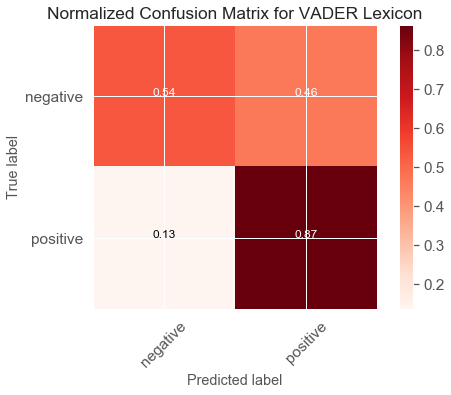

In [124]:
# VADER Lexicon  - Cleaned Data - No Stemming - Training Data
# general
import os
import pandas as pd
import numpy as np
import csv
import string
import matplotlib.pyplot as plt
import seaborn as sns
import random
import itertools
import collections
from collections import Counter
import json

# Feature Engineering
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# plots
from wordcloud import WordCloud
import plotly
import chart_studio.plotly as py
import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
cf.go_offline()

import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

# hide warnings
import warnings
warnings.filterwarnings("ignore")

print('Libraries imported')
%matplotlib inline

# Load data set
csv = 'trainingandtestdata/train_data_cleaned_feat_eng.csv'
train = pd.read_csv(csv)

# Remove completely neutral scores as no neutrals in labels
neutral = train[train.compound_scores == 0]
print('number of neutral tagged sentences is: {}'.format(len(neutral)))
# number of neutral tagged sentences is: 13324
train = train[train.compound_scores != 0]
print('neutral removed')

# Count remaining results
train.shape
# 36935

# Normalize VADER predictions. Postitive compound score is 1, neg is 0
train.loc[(train['compound_scores'] < 0), 'prediction'] = 0
train.loc[(train['compound_scores'] > 0), 'prediction'] = 1

# check the number of positive, negative VADER predicted sentences
positives = train['prediction'][train.prediction == 1]
negatives = train['prediction'][train.prediction == 0]

print('number of positve tagged sentences is:  {}'.format(len(positives)))
print('number of negative tagged sentences is: {}'.format(len(negatives)))
print('total length of the remaining data is: {}'.format(train.shape[0]))
# number of positve tagged sentences is:  24265
# number of negative tagged sentences is: 12411
# total length of the remaining data is: 36676

# Change labels to 1 is positive and 0 is negative
train['label'] = train['label'].apply(lambda x: 0 if x == 0 else 1)

# Confusion Matrix helper function
plt.style.use(style='ggplot')
plt.rcParams.update({'font.size': 12})

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    

# Compute confusion matrix
cnf_matrix = confusion_matrix(train['label'], train['prediction'])
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
fig = plt.figure(figsize=(20,15))
fig.add_subplot(3,3,1)
plot_confusion_matrix(cnf_matrix, classes=['negative', 'positive'], normalize=True,
                      title='Normalized Confusion Matrix for VADER Lexicon')

# Helper function for Classification Report 

def classification_report_asdf(test, pred, output_dict=True):
  ''' ------------------------------
  Function to return a classification report 
  as dataframe, with rounded scores. 
  --- Parameters:----
  test = test data as array
  pred = prediction data array
  output_dic = set to True
  ------------------------
  '''
  # extract scores as dictionary
  report = classification_report(test,pred, output_dict=output_dict)
  print(report)  
  df_report = pd.DataFrame(report).transpose()
  # round
  df_report[["precision","recall","f1-score"]]= df_report[["precision","recall","f1-score"]].apply(lambda x: round(x,4))
  df_report[["support"]]= df_report[["support"]].apply(lambda x: x.astype(np.int))
  # Add suport to avg
  df_report.loc['accuracy', 'support'] = df_report.loc['weighted avg', 'support']
  df_report.loc['accuracy'] = round(accuracy_score(test, pred),4)

  return df_report

# Classification reports

#--- REPORT VADER ----#
report_vader = classification_report_asdf(train['label'], train['prediction'])

#--- Format Report ----#
dfs = [report_vader]

dfs = pd.concat(
    [df.rename(columns=lambda x: x.zfill(4)) for df in dfs],
    keys=['Vader Classifier'],
    axis=1
)

# Show reports
dfs

Libraries imported
number of neutral tagged sentences is: 17261
neutral removed
number of positve tagged sentences is:  21994
number of negative tagged sentences is: 10745
total length of the remaining data is: 32739
{'0': {'precision': 0.7919962773382969, 'recall': 0.5043560718307355, 'f1-score': 0.6162647548700123, 'support': 16873}, '1': {'precision': 0.6197599345275985, 'recall': 0.859132736669608, 'f1-score': 0.7200739566825146, 'support': 15866}, 'micro avg': {'precision': 0.6762882189437673, 'recall': 0.6762882189437673, 'f1-score': 0.6762882189437673, 'support': 32739}, 'macro avg': {'precision': 0.7058781059329478, 'recall': 0.6817444042501717, 'f1-score': 0.6681693557762635, 'support': 32739}, 'weighted avg': {'precision': 0.7085269650491451, 'recall': 0.6762882189437673, 'f1-score': 0.6665728521227434, 'support': 32739}}


Vader Classifier                              
                     f1-score precision  recall     support
0                      0.6163    0.7920  0.5044  16873.0000
1                      0.7201    0.6198  0.8591  15866.0000
micro avg              0.6763    0.6763  0.6763  32739.0000
macro avg              0.6682    0.7059  0.6817  32739.0000
weighted avg           0.6666    0.7085  0.6763  32739.0000
accuracy               0.6763    0.6763  0.6763      0.6763

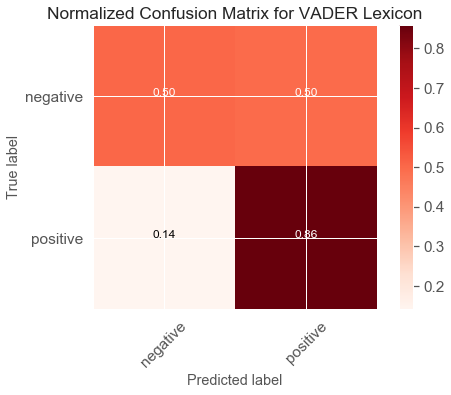

In [147]:
# VADER Lexicon  - Cleaned Data - No Stemming - Training Data
# general
import os
import pandas as pd
import numpy as np
import csv
import string
import matplotlib.pyplot as plt
import seaborn as sns
import random
import itertools
import collections
from collections import Counter
import json

# Feature Engineering
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# plots
from wordcloud import WordCloud
import plotly
import chart_studio.plotly as py
import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
cf.go_offline()

import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

# hide warnings
import warnings
warnings.filterwarnings("ignore")

print('Libraries imported')
%matplotlib inline

# Load data set
csv = 'trainingandtestdata/train_data_cleaned_feat_eng_with_stemming.csv'
train = pd.read_csv(csv)

# Remove completely neutral scores as no neutrals in labels
neutral = train[train.compound_scores == 0]
print('number of neutral tagged sentences is: {}'.format(len(neutral)))
# number of neutral tagged sentences is: 13324
train = train[train.compound_scores != 0]
print('neutral removed')

# Count remaining results
train.shape
# 36935

# Normalize VADER predictions. Postitive compound score is 1, neg is 0
train.loc[(train['compound_scores'] < 0), 'prediction'] = 0
train.loc[(train['compound_scores'] > 0), 'prediction'] = 1

# check the number of positive, negative VADER predicted sentences
positives = train['prediction'][train.prediction == 1]
negatives = train['prediction'][train.prediction == 0]

print('number of positve tagged sentences is:  {}'.format(len(positives)))
print('number of negative tagged sentences is: {}'.format(len(negatives)))
print('total length of the remaining data is: {}'.format(train.shape[0]))
# number of positve tagged sentences is:  24265
# number of negative tagged sentences is: 12411
# total length of the remaining data is: 36676

# Change labels to 1 is positive and 0 is negative
train['label'] = train['label'].apply(lambda x: 0 if x == 0 else 1)

# Confusion Matrix helper function
plt.style.use(style='ggplot')
plt.rcParams.update({'font.size': 12})

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    

# Compute confusion matrix
cnf_matrix = confusion_matrix(train['label'], train['prediction'])
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
fig = plt.figure(figsize=(20,15))
fig.add_subplot(3,3,1)
plot_confusion_matrix(cnf_matrix, classes=['negative', 'positive'], normalize=True,
                      title='Normalized Confusion Matrix for VADER Lexicon')

# Helper function for Classification Report 

def classification_report_asdf(test, pred, output_dict=True):
  ''' ------------------------------
  Function to return a classification report 
  as dataframe, with rounded scores. 
  --- Parameters:----
  test = test data as array
  pred = prediction data array
  output_dic = set to True
  ------------------------
  '''
  # extract scores as dictionary
  report = classification_report(test,pred, output_dict=output_dict)
  print(report)  
  df_report = pd.DataFrame(report).transpose()
  # round
  df_report[["precision","recall","f1-score"]]= df_report[["precision","recall","f1-score"]].apply(lambda x: round(x,4))
  df_report[["support"]]= df_report[["support"]].apply(lambda x: x.astype(np.int))
  # Add suport to avg
  df_report.loc['accuracy', 'support'] = df_report.loc['weighted avg', 'support']
  df_report.loc['accuracy'] = round(accuracy_score(test, pred),4)

  return df_report

# Classification reports

#--- REPORT VADER ----#
report_vader = classification_report_asdf(train['label'], train['prediction'])

#--- Format Report ----#
dfs = [report_vader]

dfs = pd.concat(
    [df.rename(columns=lambda x: x.zfill(4)) for df in dfs],
    keys=['Vader Classifier'],
    axis=1
)

# Show reports
dfs

In [129]:
# Machine Learning - Create Model Pipelines with GridSearchCV Features - Training Data
# general
import os
import time
import pandas as pd
import numpy as np
import csv
import string
import matplotlib.pyplot as plt
import seaborn as sns
import random
import itertools
import collections
from collections import Counter
import json
import sys
import argparse
import logging
from logging import critical, error, info, warning, debug

# text manipulation 
import nltk 
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.porter import * 
from nltk.probability import FreqDist

# Feature Engineering
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Machine Learning
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
import pickle


# hide warnings
import warnings
warnings.filterwarnings("ignore")
print('Libraries imported')
%matplotlib inline

# Load back in
train_prep = pd.read_csv('trainingandtestdata/train_data_cleaned_feat_eng.csv')

train_prep.dropna(subset=['tidy_tweet'], inplace=True)
train_prep.info()
# Dropped 333 results
# 49677

# Extracting Features
features = ['tidy_tweet', 'neu_scores', 'neg_scores', 'compound_scores', 'pos_scores']
label = ['label']

# Saving features and label data in X and y for train-test split
X = train_prep[[col for col in train_prep.columns if col in features]]
y = train_prep[label]

X.shape, y.shape
# ((49677, 5), (49677, 1))

# # splitting data into training and validation set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

print("Shapes are {} and {}".format(X_train.shape, X_test.shape))
# Shapes are (34773, 5) and (14904, 5)

# Where 4 = positive and 0 = negative, Slightly more positive results at baseline
pd.Series(y_train.values.ravel()).value_counts(normalize=True)
pd.Series(y_train.values.ravel()).value_counts(normalize=True)
# 4    0.500848
# 0    0.499152

# Helper functions

class TextSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
    
# Pipeline to convert tweets to a matrix of TF-IDF features.
tfidf = Pipeline([
                ('selector', TextSelector(key='tidy_tweet')),
                ('tfidf', TfidfVectorizer())
            ])

# Pipeline to convert tweets to a matrix of token counts
countvect = Pipeline([
                ('selector', TextSelector(key='tidy_tweet')),
                ('countvect', CountVectorizer())
            ])

# Applying tfidf and countvec to features
neu_scores =  Pipeline([
                ('selector', NumberSelector(key='neu_scores')),
                ('minmax', MinMaxScaler())
            ])
neg_scores =  Pipeline([
                ('selector', NumberSelector(key='neg_scores')),
                ('minmax', MinMaxScaler())
            ])
pos_scores =  Pipeline([
                ('selector', NumberSelector(key='pos_scores')),
                ('minmax', MinMaxScaler())
            ])

compound_scores =  Pipeline([
                ('selector', NumberSelector(key='compound_scores')),
                ('minmax', MinMaxScaler())
            ])

# defining different sets of text processors
def features_union(textProcessor):
    return FeatureUnion([('text', textProcessor),
                      ('neu_scores', neu_scores),
                      ('neg_scores', neg_scores),
                      ('pos_scores', pos_scores),
                      ('compound_scores', compound_scores)])

# Normalise labels
le = LabelEncoder().fit(y_train.values.ravel())

y_train = le.transform(y_train.values.ravel())
y_test = le.transform(y_test.values.ravel())

y_train.shape, y_test.shape
# ((34773,), (14904,))

#NAIVE BAYES - Baseline
# instantiate classifier
clf = MultinomialNB()

# combine features
features_count = features_union(countvect)

# define pipeline object 
nb_pipeline = Pipeline([('features', features_count),
                       ('nb', clf)])

# Fit classifier
nb_pipeline.fit(X_train, y_train)

# score
print("nbpipelinescore: " + str(nb_pipeline.score(X_test, y_test)))
# 0.7355743424584005


#SVM - Baseline
# instantiate classifier
svm = LinearSVC()

#  combine features
features_tfidf = features_union(tfidf)

# define pipeline object
svm_pipeline = Pipeline([('features', features_tfidf),
                       ('svm', svm)])

# Fit classifier
svm_pipeline.fit(X_train, y_train)

# score
print("svmpipelinescore:" + str(svm_pipeline.score(X_test, y_test)))
# 0.7278582930756844

# save each model
pickle.dump(nb_pipeline, open("trainingandtestdata/train_data_cleaned_feat_eng_model_pipeline_naivebayes.sav", 'wb'))
print('Naive Bayes Classifier saved')
pickle.dump(svm_pipeline, open("trainingandtestdata/train_data_cleaned_feat_eng_model_pipeline_svm.sav", 'wb'))
print('SVM Classifier saved')

# Naive Bayes
y_preds_nb = nb_pipeline.predict(X_test)
# Save predictions for evaluation as numpy arrays
np.save('trainingandtestdata/train_data_cleaned_feat_eng_model_pipeline_y_predsNB.npy', y_preds_nb)

# Support Vector Machine
y_preds_svm = svm_pipeline.predict(X_test)
# Save predictions for evaluation as numpy arrays
np.save('trainingandtestdata/train_data_cleaned_feat_eng_model_pipeline_y_predsSVM.npy', y_preds_svm)

# Naive Bayes Classifier - With GridSearchCV

# combine features
features_tfidf = features_union(tfidf)

# instantiate pipeline object
nb_pipeline = Pipeline([('feats', features_tfidf),  ('clf', MultinomialNB())])

# parameter grid (3x3x2x2x3x3x2) combinations
parameters = {
    'feats__text__tfidf__max_df': (0.5, 0.75, 1.0),
    'feats__text__tfidf__ngram_range': ((1, 1), (1, 2), (2, 2)), 
    'feats__text__tfidf__use_idf': (False, True),
    'feats__text__tfidf__binary':(False, True),
    'feats__text__tfidf__binary':('l1', 'l2', None),
    'clf__alpha': (1.0, 5.0, 10.0),
    'clf__fit_prior': (True, False),     
}

# instantiate GridSearchCV object with pipeline and parameters with 5-folds cross-validation
nb_grid = GridSearchCV(nb_pipeline, parameters, cv=5)

# start time 
nb_start = time.time()

# Fit 
nb_grid.fit(X_train, y_train)

# end time 
nb_end = time.time()
print(f"Time taken to run: {round((nb_end - nb_start)/60,1)} minutes")

# Check score
print("nbgridscore: " + str(nb_grid.score(X_test, y_test)))
# 0.7470477724100912

print('Best params: {}'.format(nb_grid.best_params_))
# Best params: {'clf__alpha': 1.0, 'clf__fit_prior': False, 'feats__text__tfidf__binary': 'l1', 'feats__text__tfidf__max_df': 0.5, 'feats__text__tfidf__ngram_range': (1, 2), 'feats__text__tfidf__use_idf': False}nb_cv_results = pd.DataFrame(nb_grid.cv_results_)
nb_cv_results.head(3)

# Support Vector Classifier  - With GridSearchCV

# combine features
features_count = features_union(tfidf)

# instantiate pipeline
svm_count_pipeline = Pipeline([('feats', features_count),  ('clf', LinearSVC())])

# parameter grid (3x3x2x3x7x2) combinations
parameters = {
    'feats__text__tfidf__max_df': (0.5, 0.75, 1.0),
    'feats__text__tfidf__ngram_range': ((1, 1), (1, 2), (2, 2)), 
    'feats__text__tfidf__use_idf': (False, True),
    'clf__loss': ('hinge', 'squared_hinge'),
    'clf__C': (0.1, 0.5, 0.6, 1, 4, 5, 10, 100),
    'clf__class_weight': (None, 'balanced')                                    
}

# instantiate GridSearchCV object with pipeline and parameters with 5-folds cross-validation
svm_grid = GridSearchCV(svm_count_pipeline, parameters, cv=5)

# start time 
svm_start = time.time()

# fit
svm_grid.fit(X_train, y_train)

# end time 
svm_end = time.time()
print(f"Time taken to run: {round((svm_end - svm_start)/60,1)} minutes")

# score
print("svmgridscore:" + str(svm_grid.score(X_test, y_test)))
# 0.7544283413848631
print('Best params: {}'.format(svm_grid.best_params_))
# Best params: {'clf__C': 0.6, 'clf__class_weight': 'balanced', 'clf__loss': 'hinge', 'feats__text__tfidf__max_df': 0.5, 'feats__text__tfidf__ngram_range': (1, 2), 'feats__text__tfidf__use_idf': False}
svm_cv_results = pd.DataFrame(svm_grid.cv_results_)
svm_cv_results.head(3)

# save best model per each classifier
joblib.dump(nb_grid, "trainingandtestdata/train_data_cleaned_feat_eng_model_grid_naivebayes.pkl")
print('Naive Bayes Classifier saved')
joblib.dump(svm_grid, "trainingandtestdata/train_data_cleaned_feat_eng_model_grid_svm.pkl")
print('SVM Classifier saved')

# Naive Bayes
y_preds_nb = nb_grid.predict(X_test)
# Save predictions for evaluation as numpy arrays
np.save('trainingandtestdata/train_data_cleaned_feat_eng_model_grid_y_predsNB.npy', y_preds_nb)

# Support Vector Machine
y_preds_svm = svm_grid.predict(X_test)
# Save predictions for evaluation as numpy arrays
np.save('trainingandtestdata/train_data_cleaned_feat_eng_model_grid_y_predsSVM.npy', y_preds_svm)

# Save test data for evaluation in the next notebook
np.save('trainingandtestdata/train_data_cleaned_feat_eng_model_y_test.npy', y_test)



Libraries imported
<class 'pandas.core.frame.DataFrame'>
Int64Index: 49677 entries, 0 to 49999
Data columns (total 8 columns):
label              49677 non-null int64
text               49677 non-null object
tidy_tweet         49677 non-null object
tokens             49677 non-null object
neg_scores         49677 non-null float64
neu_scores         49677 non-null float64
pos_scores         49677 non-null float64
compound_scores    49677 non-null float64
dtypes: float64(4), int64(1), object(3)
memory usage: 3.4+ MB
Shapes are (34773, 5) and (14904, 5)
nbpipelinescore: 0.7391304347826086
svmpipelinescore:0.7347691894793345
Naive Bayes Classifier saved
SVM Classifier saved
Time taken to run: 38.6 minutes
nbgridscore: 0.7470477724100912
Best params: {'clf__alpha': 1.0, 'clf__fit_prior': False, 'feats__text__tfidf__binary': 'l1', 'feats__text__tfidf__max_df': 0.5, 'feats__text__tfidf__ngram_range': (1, 2), 'feats__text__tfidf__use_idf': False}
Time taken to run: 171.4 minutes
svmgridscore:0

Libraries imported
Predictions and test data imported
{'0': {'precision': 0.76276910088645, 'recall': 0.7223184543637575, 'f1-score': 0.7419928825622776, 'support': 7505}, '1': {'precision': 0.73271771194049, 'recall': 0.772131369103933, 'f1-score': 0.751908396946565, 'support': 7399}, 'micro avg': {'precision': 0.7470477724100912, 'recall': 0.7470477724100912, 'f1-score': 0.7470477724100912, 'support': 14904}, 'macro avg': {'precision': 0.74774340641347, 'recall': 0.7472249117338452, 'f1-score': 0.7469506397544212, 'support': 14904}, 'weighted avg': {'precision': 0.7478502719270326, 'recall': 0.7470477724100912, 'f1-score': 0.7469153792698286, 'support': 14904}}
{'0': {'precision': 0.7585743106926698, 'recall': 0.7514990006662225, 'f1-score': 0.7550200803212852, 'support': 7505}, '1': {'precision': 0.750301245146606, 'recall': 0.7573996486011623, 'f1-score': 0.7538337368845844, 'support': 7399}, 'micro avg': {'precision': 0.7544283413848631, 'recall': 0.7544283413848631, 'f1-score': 0

Naive Bayes Classifier                               \
                           f1-score precision  recall    support   
0                            0.7420    0.7628  0.7223   7505.000   
1                            0.7519    0.7327  0.7721   7399.000   
micro avg                    0.7470    0.7470  0.7470  14904.000   
macro avg                    0.7470    0.7477  0.7472  14904.000   
weighted avg                 0.7469    0.7479  0.7470  14904.000   
accuracy                     0.7470    0.7470  0.7470      0.747   

             SVM Classifier                                
                   f1-score precision  recall     support  
0                    0.7550    0.7586  0.7515   7505.0000  
1                    0.7538    0.7503  0.7574   7399.0000  
micro avg            0.7544    0.7544  0.7544  14904.0000  
macro avg            0.7544    0.7544  0.7544  14904.0000  
weighted avg         0.7544    0.7545  0.7544  14904.0000  
accuracy             0.7544    0.7544  0.7544      0.7544

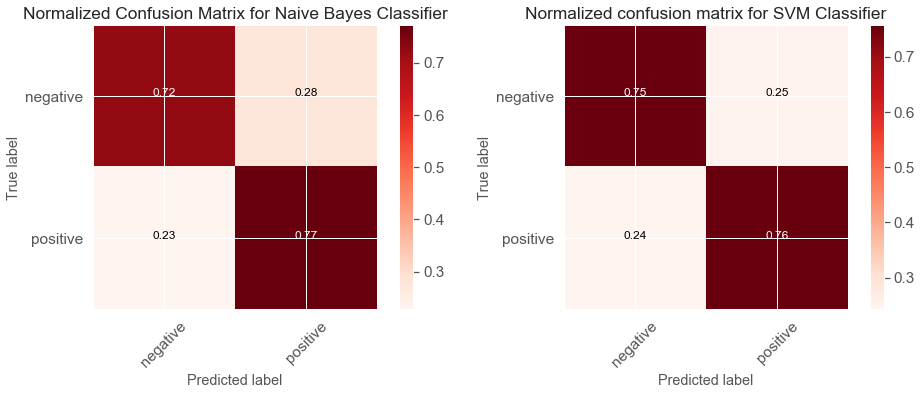

In [130]:
# Machine Learning - Cleaned Data and Pipelines with GridSearchCV Features Results - Training Data
# general
import os
import pandas as pd
import numpy as np
import csv
import string
import matplotlib.pyplot as plt
import seaborn as sns
import random
import itertools
import collections
from collections import Counter

# tweets
import tweepy as tw
import re
from collections import Counter
from string import punctuation
from tweepy import OAuthHandler
import json

# text manipulation 
import nltk 
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.porter import * 

# plots
from wordcloud import WordCloud
import plotly
import chart_studio.plotly as py
import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
cf.go_offline()

# Feature Engineering
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Machine Learning
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

# Model Evaluation
from numpy import loadtxt
from keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import itertools

# hide warnings
import warnings
warnings.filterwarnings("ignore")

print('Libraries imported')
%matplotlib inline

# Set up labels
labels = LabelEncoder().fit(['negative', 'positive'])

# Import supervised learning model predictions
y_pred_nb = np.load('trainingandtestdata/train_data_cleaned_feat_eng_model_grid_y_predsNB.npy')
y_pred_svm = np.load('trainingandtestdata/train_data_cleaned_feat_eng_model_grid_y_predsSVM.npy')

# Import supervised learning models test data
y_test = np.load('trainingandtestdata/train_data_cleaned_feat_eng_model_y_test.npy')

print('Predictions and test data imported')

# Confusion Matrix helper function
plt.style.use(style='ggplot')
plt.rcParams.update({'font.size': 12})

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_nb)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
fig = plt.figure(figsize=(20,15))
fig.add_subplot(3,3,1)
plot_confusion_matrix(cnf_matrix, classes=['negative', 'positive'], normalize=True,
                      title='Normalized Confusion Matrix for Naive Bayes Classifier')

#--- Support Vector Machine Classifier ---#

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_svm)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
fig.add_subplot(3,3,2)
plot_confusion_matrix(cnf_matrix, classes=['negative', 'positive'], normalize=True,
                      title='Normalized confusion matrix for SVM Classifier')

# Helper function for Classification Report 

def classification_report_asdf(test, pred, output_dict=True):
  ''' ------------------------------
  Function to return a classification report 
  as dataframe, with rounded scores. 
  --- Parameters:----
  test = test data as array
  pred = prediction data array
  output_dic = set to True
  ------------------------
  '''
  # extract scores as dictionary
  report = classification_report(test,pred, output_dict=output_dict)
  print(report)  
  df_report = pd.DataFrame(report).transpose()
  #round
  df_report[["precision","recall","f1-score"]]= df_report[["precision","recall","f1-score"]].apply(lambda x: round(x,4))
  df_report[["support"]]= df_report[["support"]].apply(lambda x: x.astype(np.int))
  # Add suport to avg
  df_report.loc['accuracy', 'support'] = df_report.loc['weighted avg', 'support']
  df_report.loc['accuracy'] = round(accuracy_score(test, pred),4)

  return df_report

# Classification reports for Supervised ML models

#--- Naive Bayes Classifier ----#
report_nb = classification_report_asdf(y_test, y_pred_nb)

#--- SVM Classifier ----#
report_svm = classification_report_asdf(y_test, y_pred_svm)

#--- Add reports together ----#
SML_dfs = [report_nb, report_svm]

SML_dfs_combined = pd.concat(
    [df.rename(columns=lambda x: x.zfill(4)) for df in SML_dfs],
    keys=['Naive Bayes Classifier', 'SVM Classifier'],
    axis=1
)

# Show reports
SML_dfs_combined

In [153]:
# Machine Learning - Create Model Pipelines with GridSearchCV Features - Lexicon Baselined - Training Data
# general
import os
import time
import pandas as pd
import numpy as np
import csv
import string
import matplotlib.pyplot as plt
import seaborn as sns
import random
import itertools
import collections
from collections import Counter
import json
import sys
import argparse
import logging
from logging import critical, error, info, warning, debug

# text manipulation 
import nltk 
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.porter import * 
from nltk.probability import FreqDist

# Feature Engineering
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Machine Learning
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
import pickle


# hide warnings
import warnings
warnings.filterwarnings("ignore")
print('Libraries imported')
%matplotlib inline

# Load back in
train_prep = pd.read_csv('trainingandtestdata/train_data_cleaned_feat_eng_lexicon_baselined.csv')

train_prep.dropna(subset=['tidy_tweet'], inplace=True)
train_prep.info()
# Dropped 333 results
# 49677

# Extracting Features
features = ['tidy_tweet', 'neu_scores', 'neg_scores', 'compound_scores', 'pos_scores']
label = ['label']

# Saving features and label data in X and y for train-test split
X = train_prep[[col for col in train_prep.columns if col in features]]
y = train_prep[label]

X.shape, y.shape
# ((49677, 5), (49677, 1))

# # splitting data into training and validation set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

print("Shapes are {} and {}".format(X_train.shape, X_test.shape))
# Shapes are (34773, 5) and (14904, 5)

# Where 4 = positive and 0 = negative, Slightly more positive results at baseline
pd.Series(y_train.values.ravel()).value_counts(normalize=True)
pd.Series(y_train.values.ravel()).value_counts(normalize=True)
# 4    0.500848
# 0    0.499152

# Helper functions

class TextSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
    
# Pipeline to convert tweets to a matrix of TF-IDF features.
tfidf = Pipeline([
                ('selector', TextSelector(key='tidy_tweet')),
                ('tfidf', TfidfVectorizer())
            ])

# Pipeline to convert tweets to a matrix of token counts
countvect = Pipeline([
                ('selector', TextSelector(key='tidy_tweet')),
                ('countvect', CountVectorizer())
            ])

# Applying tfidf and countvec to features
neu_scores =  Pipeline([
                ('selector', NumberSelector(key='neu_scores')),
                ('minmax', MinMaxScaler())
            ])
neg_scores =  Pipeline([
                ('selector', NumberSelector(key='neg_scores')),
                ('minmax', MinMaxScaler())
            ])
pos_scores =  Pipeline([
                ('selector', NumberSelector(key='pos_scores')),
                ('minmax', MinMaxScaler())
            ])

compound_scores =  Pipeline([
                ('selector', NumberSelector(key='compound_scores')),
                ('minmax', MinMaxScaler())
            ])

# defining different sets of text processors
def features_union(textProcessor):
    return FeatureUnion([('text', textProcessor),
                      ('neu_scores', neu_scores),
                      ('neg_scores', neg_scores),
                      ('pos_scores', pos_scores),
                      ('compound_scores', compound_scores)])

# Normalise labels
le = LabelEncoder().fit(y_train.values.ravel())

y_train = le.transform(y_train.values.ravel())
y_test = le.transform(y_test.values.ravel())

y_train.shape, y_test.shape
# ((34773,), (14904,))

#NAIVE BAYES - Baseline
# instantiate classifier
clf = MultinomialNB()

# combine features
features_count = features_union(countvect)

# define pipeline object 
nb_pipeline = Pipeline([('features', features_count),
                       ('nb', clf)])

# Fit classifier
nb_pipeline.fit(X_train, y_train)

# score
print("nbpipelinescore: " + str(nb_pipeline.score(X_test, y_test)))
# 0.7355743424584005


#SVM - Baseline
# instantiate classifier
svm = LinearSVC()

#  combine features
features_tfidf = features_union(tfidf)

# define pipeline object
svm_pipeline = Pipeline([('features', features_tfidf),
                       ('svm', svm)])

# Fit classifier
svm_pipeline.fit(X_train, y_train)

# score
print("svmpipelinescore:" + str(svm_pipeline.score(X_test, y_test)))
# 0.7278582930756844

# save each model
pickle.dump(nb_pipeline, open("trainingandtestdata/train_data_cleaned_feat_eng_lexicon_baselined_model_pipeline_naivebayes.sav", 'wb'))
print('Naive Bayes Classifier saved')
pickle.dump(svm_pipeline, open("trainingandtestdata/train_data_cleaned_feat_eng_lexicon_baselined_model_pipeline_svm.sav", 'wb'))
print('SVM Classifier saved')

# Naive Bayes
y_preds_nb = nb_pipeline.predict(X_test)
# Save predictions for evaluation as numpy arrays
np.save('trainingandtestdata/train_data_cleaned_feat_eng_model_lexicon_baselined_pipeline_y_predsNB.npy', y_preds_nb)

# Support Vector Machine
y_preds_svm = svm_pipeline.predict(X_test)
# Save predictions for evaluation as numpy arrays
np.save('trainingandtestdata/train_data_cleaned_feat_eng_model_lexicon_baselined_pipeline_y_predsSVM.npy', y_preds_svm)

# Naive Bayes Classifier - With GridSearchCV

# combine features
features_tfidf = features_union(tfidf)

# instantiate pipeline object
nb_pipeline = Pipeline([('feats', features_tfidf),  ('clf', MultinomialNB())])

# parameter grid (3x3x2x2x3x3x2) combinations
parameters = {
    'feats__text__tfidf__max_df': (0.5, 0.75, 1.0),
    'feats__text__tfidf__ngram_range': ((1, 1), (1, 2), (2, 2)), 
    'feats__text__tfidf__use_idf': (False, True),
    'feats__text__tfidf__binary':(False, True),
    'feats__text__tfidf__binary':('l1', 'l2', None),
    'clf__alpha': (1.0, 5.0, 10.0),
    'clf__fit_prior': (True, False),     
}

# instantiate GridSearchCV object with pipeline and parameters with 5-folds cross-validation
nb_grid = GridSearchCV(nb_pipeline, parameters, cv=5)

# start time 
nb_start = time.time()

# Fit 
nb_grid.fit(X_train, y_train)

# end time 
nb_end = time.time()
print(f"Time taken to run: {round((nb_end - nb_start)/60,1)} minutes")

# Check score
print("nbgridscore: " + str(nb_grid.score(X_test, y_test)))
# 0.7470477724100912

print('Best params: {}'.format(nb_grid.best_params_))
# Best params: {'clf__alpha': 1.0, 'clf__fit_prior': False, 'feats__text__tfidf__binary': 'l1', 'feats__text__tfidf__max_df': 0.5, 'feats__text__tfidf__ngram_range': (1, 2), 'feats__text__tfidf__use_idf': False}nb_cv_results = pd.DataFrame(nb_grid.cv_results_)
nb_cv_results.head(3)

# Support Vector Classifier  - With GridSearchCV

# combine features
features_count = features_union(tfidf)

# instantiate pipeline
svm_count_pipeline = Pipeline([('feats', features_count),  ('clf', LinearSVC())])

# parameter grid (3x3x2x3x7x2) combinations
parameters = {
    'feats__text__tfidf__max_df': (0.5, 0.75, 1.0),
    'feats__text__tfidf__ngram_range': ((1, 1), (1, 2), (2, 2)), 
    'feats__text__tfidf__use_idf': (False, True),
    'clf__loss': ('hinge', 'squared_hinge'),
    'clf__C': (0.1, 0.5, 0.6, 1, 4, 5, 10, 100),
    'clf__class_weight': (None, 'balanced')                                    
}

# instantiate GridSearchCV object with pipeline and parameters with 5-folds cross-validation
svm_grid = GridSearchCV(svm_count_pipeline, parameters, cv=5)

# start time 
svm_start = time.time()

# fit
svm_grid.fit(X_train, y_train)

# end time 
svm_end = time.time()
print(f"Time taken to run: {round((svm_end - svm_start)/60,1)} minutes")

# score
print("svmgridscore:" + str(svm_grid.score(X_test, y_test)))
# 0.7544283413848631
print('Best params: {}'.format(svm_grid.best_params_))
# Best params: {'clf__C': 0.6, 'clf__class_weight': 'balanced', 'clf__loss': 'hinge', 'feats__text__tfidf__max_df': 0.5, 'feats__text__tfidf__ngram_range': (1, 2), 'feats__text__tfidf__use_idf': False}
svm_cv_results = pd.DataFrame(svm_grid.cv_results_)
svm_cv_results.head(3)

# save best model per each classifier
joblib.dump(nb_grid, "trainingandtestdata/train_data_cleaned_feat_eng_lexicon_baselined_model_grid_naivebayes.pkl")
print('Naive Bayes Classifier saved')
joblib.dump(svm_grid, "trainingandtestdata/train_data_cleaned_feat_eng_lexicon_baselined_model_grid_svm.pkl")
print('SVM Classifier saved')

# Naive Bayes
y_preds_nb = nb_grid.predict(X_test)
# Save predictions for evaluation as numpy arrays
np.save('trainingandtestdata/train_data_cleaned_feat_eng_lexicon_baselined_model_grid_y_predsNB.npy', y_preds_nb)

# Support Vector Machine
y_preds_svm = svm_grid.predict(X_test)
# Save predictions for evaluation as numpy arrays
np.save('trainingandtestdata/train_data_cleaned_feat_eng_lexicon_baselined_model_grid_y_predsSVM.npy', y_preds_svm)

# Save test data for evaluation in the next notebook
np.save('trainingandtestdata/train_data_cleaned_feat_eng_lexicon_baselined_model_y_test.npy', y_test)



Libraries imported
<class 'pandas.core.frame.DataFrame'>
Int64Index: 49677 entries, 0 to 49999
Data columns (total 8 columns):
label              49677 non-null int64
text               49677 non-null object
tidy_tweet         49677 non-null object
tokens             49677 non-null object
neg_scores         49677 non-null float64
neu_scores         49677 non-null float64
pos_scores         49677 non-null float64
compound_scores    49677 non-null float64
dtypes: float64(4), int64(1), object(3)
memory usage: 3.4+ MB
Shapes are (34773, 5) and (14904, 5)
nbpipelinescore: 0.7427536231884058
svmpipelinescore:0.7409420289855072
Naive Bayes Classifier saved
SVM Classifier saved
Time taken to run: 32.2 minutes
nbgridscore: 0.7504696725711218
Best params: {'clf__alpha': 1.0, 'clf__fit_prior': True, 'feats__text__tfidf__binary': None, 'feats__text__tfidf__max_df': 0.5, 'feats__text__tfidf__ngram_range': (1, 2), 'feats__text__tfidf__use_idf': False}
Time taken to run: 142.8 minutes
svmgridscore:0.

Libraries imported
Predictions and test data imported
{'0': {'precision': 0.76828231292517, 'recall': 0.7223184543637575, 'f1-score': 0.7445917176018131, 'support': 7505}, '1': {'precision': 0.7344546381243628, 'recall': 0.7790241924584403, 'f1-score': 0.7560831639010954, 'support': 7399}, 'micro avg': {'precision': 0.7504696725711218, 'recall': 0.7504696725711218, 'f1-score': 0.7504696725711217, 'support': 14904}, 'macro avg': {'precision': 0.7513684755247665, 'recall': 0.7506713234110989, 'f1-score': 0.7503374407514543, 'support': 14904}, 'weighted avg': {'precision': 0.7514887698594714, 'recall': 0.7504696725711218, 'f1-score': 0.7502965761074754, 'support': 14904}}
{'0': {'precision': 0.7626168224299066, 'recall': 0.7610926049300466, 'f1-score': 0.7618539513171058, 'support': 7505}, '1': {'precision': 0.7581602373887241, 'recall': 0.759697256385998, 'f1-score': 0.7589279686761627, 'support': 7399}, 'micro avg': {'precision': 0.7603998926462695, 'recall': 0.7603998926462695, 'f1-sco

Naive Bayes Classifier                                \
                           f1-score precision  recall     support   
0                            0.7446    0.7683  0.7223   7505.0000   
1                            0.7561    0.7345  0.7790   7399.0000   
micro avg                    0.7505    0.7505  0.7505  14904.0000   
macro avg                    0.7503    0.7514  0.7507  14904.0000   
weighted avg                 0.7503    0.7515  0.7505  14904.0000   
accuracy                     0.7505    0.7505  0.7505      0.7505   

             SVM Classifier                                
                   f1-score precision  recall     support  
0                    0.7619    0.7626  0.7611   7505.0000  
1                    0.7589    0.7582  0.7597   7399.0000  
micro avg            0.7604    0.7604  0.7604  14904.0000  
macro avg            0.7604    0.7604  0.7604  14904.0000  
weighted avg         0.7604    0.7604  0.7604  14904.0000  
accuracy             0.7604    0.7604  0.7604      0.7604

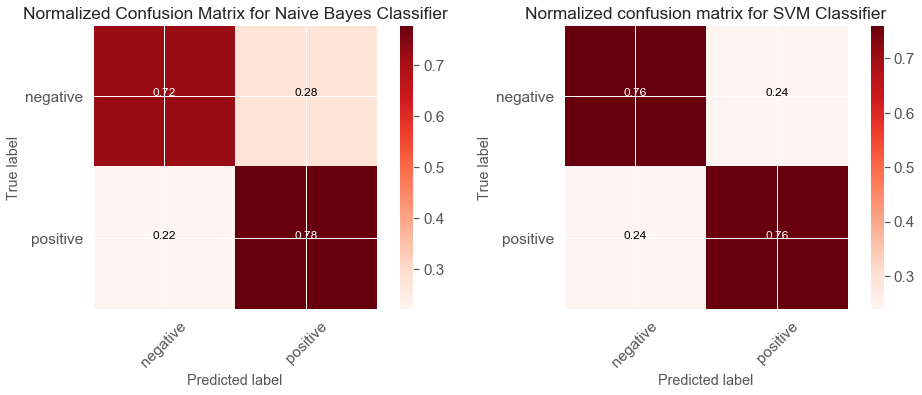

In [154]:
# Machine Learning - Cleaned Data and Pipelines with GridSearchCV Features Results - Lexicon Baselined - Training Data
# general
import os
import pandas as pd
import numpy as np
import csv
import string
import matplotlib.pyplot as plt
import seaborn as sns
import random
import itertools
import collections
from collections import Counter

# tweets
import tweepy as tw
import re
from collections import Counter
from string import punctuation
from tweepy import OAuthHandler
import json

# text manipulation 
import nltk 
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.porter import * 

# plots
from wordcloud import WordCloud
import plotly
import chart_studio.plotly as py
import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
cf.go_offline()

# Feature Engineering
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Machine Learning
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

# Model Evaluation
from numpy import loadtxt
from keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import itertools

# hide warnings
import warnings
warnings.filterwarnings("ignore")

print('Libraries imported')
%matplotlib inline

# Set up labels
labels = LabelEncoder().fit(['negative', 'positive'])

# Import supervised learning model predictions
y_pred_nb = np.load('trainingandtestdata/train_data_cleaned_feat_eng_lexicon_baselined_model_grid_y_predsNB.npy')
y_pred_svm = np.load('trainingandtestdata/train_data_cleaned_feat_eng_lexicon_baselined_model_grid_y_predsSVM.npy')

# Import supervised learning models test data
y_test = np.load('trainingandtestdata/train_data_cleaned_feat_eng_lexicon_baselined_model_y_test.npy')

print('Predictions and test data imported')

# Confusion Matrix helper function
plt.style.use(style='ggplot')
plt.rcParams.update({'font.size': 12})

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_nb)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
fig = plt.figure(figsize=(20,15))
fig.add_subplot(3,3,1)
plot_confusion_matrix(cnf_matrix, classes=['negative', 'positive'], normalize=True,
                      title='Normalized Confusion Matrix for Naive Bayes Classifier')

#--- Support Vector Machine Classifier ---#

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_svm)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
fig.add_subplot(3,3,2)
plot_confusion_matrix(cnf_matrix, classes=['negative', 'positive'], normalize=True,
                      title='Normalized confusion matrix for SVM Classifier')

# Helper function for Classification Report 

def classification_report_asdf(test, pred, output_dict=True):
  ''' ------------------------------
  Function to return a classification report 
  as dataframe, with rounded scores. 
  --- Parameters:----
  test = test data as array
  pred = prediction data array
  output_dic = set to True
  ------------------------
  '''
  # extract scores as dictionary
  report = classification_report(test,pred, output_dict=output_dict)
  print(report)  
  df_report = pd.DataFrame(report).transpose()
  #round
  df_report[["precision","recall","f1-score"]]= df_report[["precision","recall","f1-score"]].apply(lambda x: round(x,4))
  df_report[["support"]]= df_report[["support"]].apply(lambda x: x.astype(np.int))
  # Add suport to avg
  df_report.loc['accuracy', 'support'] = df_report.loc['weighted avg', 'support']
  df_report.loc['accuracy'] = round(accuracy_score(test, pred),4)

  return df_report

# Classification reports for Supervised ML models

#--- Naive Bayes Classifier ----#
report_nb = classification_report_asdf(y_test, y_pred_nb)

#--- SVM Classifier ----#
report_svm = classification_report_asdf(y_test, y_pred_svm)

#--- Add reports together ----#
SML_dfs = [report_nb, report_svm]

SML_dfs_combined = pd.concat(
    [df.rename(columns=lambda x: x.zfill(4)) for df in SML_dfs],
    keys=['Naive Bayes Classifier', 'SVM Classifier'],
    axis=1
)

# Show reports
SML_dfs_combined

Libraries imported
<class 'pandas.core.frame.DataFrame'>
Int64Index: 49677 entries, 0 to 49999
Data columns (total 8 columns):
label              49677 non-null int64
text               49677 non-null object
tidy_tweet         49677 non-null object
tokens             49677 non-null object
neg_scores         49677 non-null float64
neu_scores         49677 non-null float64
pos_scores         49677 non-null float64
compound_scores    49677 non-null float64
dtypes: float64(4), int64(1), object(3)
memory usage: 3.4+ MB
{'get': 1, 'day': 2, 'good': 3, 'work': 4, 'like': 5, 'love': 6, 'today': 7, 'time': 8, 'go': 9, 'got': 10, 'thank': 11, 'back': 12, 'want': 13, 'lol': 14, 'one': 15, 'miss': 16, 'know': 17, 'realli': 18, 'think': 19, 'see': 20, 'feel': 21, 'still': 22, 'watch': 23, 'need': 24, 'hope': 25, 'make': 26, 'night': 27, 'well': 28, 'home': 29, 'look': 30, 'new': 31, 'come': 32, 'much': 33, 'twitter': 34, 'morn': 35, 'sleep': 36, 'last': 37, 'wish': 38, 'tomorrow': 39, 'great': 40, 

[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
			Feature Shapes:
Train set X: 		(34773, 39) 
Train set Y: 		(34773, 2) 
Test set X: 		(14904, 39) 
Test set Y: 		(14904, 2)
Building model...
Model: "LSTMModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 39, 128)           1280000   
_________________________________________________________________
dropout_4 (Dropout)          (None, 39, 128)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 200)               263200    
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 402       
Total params

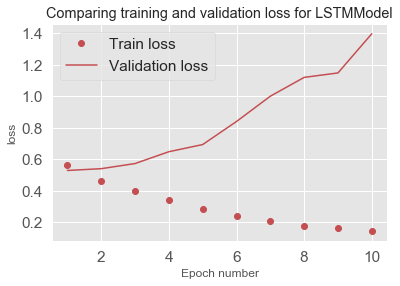

Minimum validation loss reached in epoch 1
start fit
1087/1087 [==============================] - 132s 121ms/step - loss: 0.3492 - accuracy: 0.8622
start eval
466/466 [==============================] - 8s 15ms/step - loss: 0.6353 - accuracy: 0.7159

Test accuracy: 71.59%
Saved LSTM model to drive
LSTM model predictions saved to drive


In [132]:
# LTSM - Create Model With Cleaned Data - Training Data
# general
import os
import time
import pandas as pd
import numpy as np
import csv
import string
import matplotlib.pyplot as plt
import seaborn as sns
import random
import itertools
import collections
from collections import Counter

# tweets
import tweepy as tw
import re
from collections import Counter
from string import punctuation
from tweepy import OAuthHandler
import json

# text manipulation 
import nltk 
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.porter import * 

# plots
from wordcloud import WordCloud
import plotly
import chart_studio.plotly as py
import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
cf.go_offline()

# Feature Engineering
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Machine Learning
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

# Deep Learning
import torch
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras import regularizers
from keras.layers import Dense, Embedding, LSTM, Dropout

# hide warnings
import warnings
warnings.filterwarnings("ignore")


# set plot preferences
plt.style.use(style='ggplot')
plt.rcParams['figure.figsize'] = (10, 6)
pd.set_option("display.max_colwidth", 200) 

print('Libraries imported')
%matplotlib inline

# Load back in
train_prep = pd.read_csv('trainingandtestdata/train_data_cleaned_feat_eng.csv')
train_prep.dropna(subset=['tidy_tweet'], inplace=True)
train_prep.info()
# Dropped 333 results
# 49677

# Parameter indicating the number of words
nb_words = 10000  

## create the tokenizer (tweets have been preprocessed so no need for filters)
tk = Tokenizer(num_words=nb_words)

# fit the tokenizer on tweets
tk.fit_on_texts(train_prep.tidy_tweet)

# integer encode tweets
tweets_seq = tk.texts_to_sequences(train_prep.tidy_tweet)

print(tk.word_index)
print()
print(tweets_seq)

# stats about vocabulary
print('Unique words: ', len((tweets_seq)))
print()

# print first encoded tweet
print('Encoded tweet: \n', tweets_seq[:1])

# Maximum length since maximum tweet word count is 39.
max_len = 39

# Convert sequences into 2-D Numpy arrays
features = pad_sequences(tweets_seq, maxlen=max_len)

# test statements 
assert len(features)==len(tweets_seq), "The features should have as many rows as tweets."
assert len(features[0])==max_len, "Each feature row should contain the mex length of values."

# print first 10 values of the first 30 batches 
print(features[:10,:10])

# to hot-encode
train_prep["label"] = train_prep["label"].astype("category")
train_prep.label.describe()

## split data into training and test data (features and labels, x and y)
# data needs to be as array
labels = pd.get_dummies(train_prep['label']).values
# labels = np.asarray(train_prep.label.values)

X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size = 0.3, random_state = 42)

## print out the shapes of the resultant feature data
print("\t\t\tFeature Shapes:")
print("Train set X: \t\t{}".format(X_train.shape),
      "\nTrain set Y: \t\t{}".format(Y_train.shape),
      "\nTest set X: \t\t{}".format(X_test.shape),
      "\nTest set Y: \t\t{}".format(Y_test.shape))
    
#--- Parameters----#

# encodes input sequence dense vectors 
embed_dim = 128

# transforms the vector sequence into a single vector
lstm_out = 200

# epochs
epochs = 10

#------# Build the LSTM model #-----------------#

print('Building model...') 

# Initialising the RNN
model = Sequential()

#adding an input layer and the first hidden layer
model.add(Embedding(10000, embed_dim, 
                    input_length = features.shape[1]
                   )) 
model.add(Dropout(0.2))
# Adding the second hidden layer
model.add(LSTM(lstm_out, recurrent_dropout = 0.2, dropout = 0.2))
# Adding the output layer
model.add(Dense(2, activation='softmax'))

# Compile model
model.compile( optimizer='adam', # optimizer
              loss = 'categorical_crossentropy', # loss function
              metrics = ['accuracy']) # list of metrics

model._name = 'LSTMModel'
print(model.summary())

# Fit the model
history = model.fit(x=X_train, y=Y_train, 
                    validation_split=0.30,
                    epochs = epochs, verbose = 1)

# Helper functions

def eval_metric(model, history, metric_name):
    '''
    Function to evaluate a trained model on a chosen metric. 
    Training and validation metric are plotted in a
    line chart for each epoch.
    
    Parameters:
        history : model training history
        metric_name : loss or accuracy
    Output:
        line chart with epochs of x-axis and metric on
        y-axis
    '''
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, epochs + 1)

    plt.plot(e, metric, 'ro', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'r', label='Validation ' + metric_name)
    plt.xlabel('Epoch number')
    plt.ylabel(metric_name)
    plt.title('Comparing training and validation ' + metric_name + ' for ' + model.name)
    plt.legend()
    plt.show()


def optimal_epoch(model_hist):
    '''
    Function to return the epoch number where the validation loss is
    at its minimum
    
    Parameters:
        model_hist : training history of model
    Output:
        epoch number with minimum validation loss
    '''
    min_epoch = np.argmin(model_hist.history['val_loss']) + 1
    print("Minimum validation loss reached in epoch {}".format(min_epoch))
    return min_epoch

def test_model(model, X_train, y_train, X_test, y_test, epoch_stop):
    '''
    Function to test the model on new data after training it
    on the full training data with the optimal number of epochs.
    
    Parameters:
        model : trained model
        X_train : training features
        y_train : training target
        X_test : test features
        y_test : test target
        epochs : optimal number of epochs
    Output:
        test accuracy and test loss
    '''
    print('start fit')
    model.fit(X_train
              , y_train
              , epochs=epoch_stop
              , verbose=1)
    print('start eval')
    results = model.evaluate(X_test, y_test)
    print()
    print('Test accuracy: {0:.2f}%'.format(results[1]*100))
    return results

eval_metric(model, history, 'loss')
optimal_epoch(history)

base_min = 1 # first model
# Training on the full train data and evaluation on test data on first model
base_results = test_model(model, X_train, Y_train, X_test, Y_test, base_min)

# save first model and architecture
model.save('trainingandtestdata/train_data_cleaned_LSTM_model.h5')
print('Saved LSTM model to drive')

# saving predictions
X_train, X_test, Y_train, Y_test

#-- LSTM model ----#
y_preds_LSTM = model.predict(X_test)

# Save predictions for evaluation as numpy arrays
np.save('trainingandtestdata/train_data_cleaned_y_predsLSTM.npy', y_preds_LSTM)
print('LSTM model predictions saved to drive')

# Save test data
np.save('trainingandtestdata/train_data_cleaned_y_testLSTM.npy', Y_test)

Libraries imported
Predictions and test data imported
{'0': {'precision': 0.7233983672339837, 'recall': 0.7005225780517218, 'f1-score': 0.7117767188563648, 'support': 7463}, '1': {'precision': 0.7088706525986713, 'recall': 0.731353312726784, 'f1-score': 0.7199364995369758, 'support': 7441}, 'micro avg': {'precision': 0.7159151905528717, 'recall': 0.7159151905528717, 'f1-score': 0.7159151905528718, 'support': 14904}, 'macro avg': {'precision': 0.7161345099163274, 'recall': 0.7159379453892529, 'f1-score': 0.7158566091966703, 'support': 14904}, 'weighted avg': {'precision': 0.7161452321963186, 'recall': 0.7159151905528717, 'f1-score': 0.7158505868142571, 'support': 14904}}


LSTM Classifier                              
                    f1-score precision  recall     support
0                     0.7118    0.7234  0.7005   7463.0000
1                     0.7199    0.7089  0.7314   7441.0000
micro avg             0.7159    0.7159  0.7159  14904.0000
macro avg             0.7159    0.7161  0.7159  14904.0000
weighted avg          0.7159    0.7161  0.7159  14904.0000
accuracy              0.7159    0.7159  0.7159      0.7159

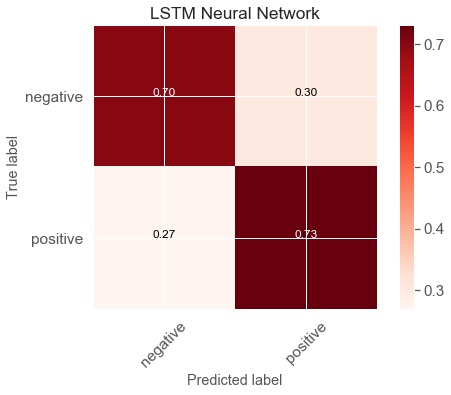

In [133]:
# LTSM - Cleaned Data Results - Training Data
# general
import os
import pandas as pd
import numpy as np
import csv
import string
import matplotlib.pyplot as plt
import seaborn as sns
import random
import itertools
import collections
from collections import Counter

# tweets
import tweepy as tw
import re
from collections import Counter
from string import punctuation
from tweepy import OAuthHandler
import json

# text manipulation 
import nltk 
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.porter import * 

# plots
from wordcloud import WordCloud
import plotly
import chart_studio.plotly as py
import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
cf.go_offline()

# Feature Engineering
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Machine Learning
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

# Model Evaluation
from numpy import loadtxt
from keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import itertools

# set plot preferences
plt.style.use(style='ggplot')
plt.rcParams['figure.figsize'] = (10, 6)
pd.set_option("display.max_colwidth", 200) 

# hide warnings
import warnings
warnings.filterwarnings("ignore")

print('Libraries imported')
%matplotlib inline

# Set up labels
labels = LabelEncoder().fit(['negative', 'positive'])

# Import deep learning predictions
y_preds_LSTM = np.load('trainingandtestdata/train_data_cleaned_y_predsLSTM.npy')

# To output vector of labels for confusion matrix
y_preds_LSTM = np.argmax(y_preds_LSTM, axis=1)

# Import deep learning test data
Y_test = np.load('trainingandtestdata/train_data_cleaned_y_testLSTM.npy')
Y_test = np.argmax(Y_test, axis = 1)


print('Predictions and test data imported')

# Confusion Matrix helper function
plt.style.use(style='ggplot')
plt.rcParams.update({'font.size': 12})

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
#--- LSTM Recurrent Neural Network ---#

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test, y_preds_LSTM)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
fig = plt.figure(figsize=(20,15))
fig.add_subplot(3,3,1)
plot_confusion_matrix(cnf_matrix, classes=['negative', 'positive'], normalize=True,
                      title='LSTM Neural Network')

# Helper function for Classification Report 

def classification_report_asdf(test, pred, output_dict=True):
  ''' ------------------------------
  Function to return a classification report 
  as dataframe, with rounded scores. 
  --- Parameters:----
  test = test data as array
  pred = prediction data array
  output_dic = set to True
  ------------------------
  '''
  # extract scores as dictionary
  report = classification_report(test,pred, output_dict=output_dict)
  print(report)  
  df_report = pd.DataFrame(report).transpose()
  #round
  df_report[["precision","recall","f1-score"]]= df_report[["precision","recall","f1-score"]].apply(lambda x: round(x,4))
  df_report[["support"]]= df_report[["support"]].apply(lambda x: x.astype(np.int))
  # Add suport to avg
  df_report.loc['accuracy', 'support'] = df_report.loc['weighted avg', 'support']
  df_report.loc['accuracy'] = round(accuracy_score(test, pred),4)

  return df_report

# Classification report for RNN models

#---- LSTM Network ----#
report_LSTM = classification_report_asdf(Y_test, y_preds_LSTM)

#--- Add reports together ----#
SML_dfs = [report_LSTM]

SML_dfs_combined = pd.concat(
    [df.rename(columns=lambda x: x.zfill(4)) for df in SML_dfs],
    keys=['LSTM Classifier'],
    axis=1
)

# Show reports
SML_dfs_combined


In [ ]:
MODEL APPLICATION

In [ ]:
ANALYSIS DATA CLEANING AND FEATURE ENGINEERING

In [ ]:
# Data Cleaning - Research Data - Add Column Headings & Order by date
# general
import os
import pandas as pd
import csv
import string
import time

# create column names
col_names=['id', 'date','text']

# csv = '(corona OR covid OR sarscov2 OR covid19 OR coronavirus OR cv19 OR covid-19) AND ("boris johnson" OR "borisjohnson" or "boris")_data2.csv'
csv = '(corona OR covid OR sarscov2 OR covid19 OR coronavirus OR cv19 OR covid-19) AND ("nicola sturgeon" OR "nicolasturgeon" OR "sturgeon")_data2.csv'

# read csv
df = pd.read_csv(csv, names=col_names)

# Sort dataframe by date column
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by='date',ascending=True)
df = df.reset_index().drop('index',axis=1)

# Save as csv
# df.to_csv('boris_cleaned.csv',index=False)
df.to_csv('sturgeon_cleaned.csv',index=False)

In [213]:
# Data Cleaning and Feature Adding - Research Data - Baseline Lexicon
# general
import os
import pandas as pd
import numpy as np
import csv
import string
import matplotlib.pyplot as plt
import seaborn as sns
import random
import itertools
import collections
from collections import Counter

# tweets
import tweepy as tw
import re
from collections import Counter
from string import punctuation
from tweepy import OAuthHandler
import json

# text manipulation 
import nltk 
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.porter import * 

# Feature Engineering
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# hide warnings
import warnings
warnings.filterwarnings("ignore")

print('Libraries imported')

# nltk.download('stopwords')
stop_words = stopwords.words('english')

# cleaning helper function
def processTweet(tweet):
    """
    Takes in a string of text, then performs the following:
    1. Removes links, special characters and other bulk cleaning
    2. Returns a list of the tidy text
    """
    # Remove HTML special entities (e.g. &amp;)
    tweet = re.sub(r'\&\w*;', '', tweet)
    #Convert @username to AT_USER
    tweet = re.sub('@[^\s]+','',tweet)
    # Remove tickers
    tweet = re.sub(r'\$\w*', '', tweet)
    # To lowercase
    tweet = tweet.lower()
    # Remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)
    # Remove hashtags
    tweet = re.sub(r'#\w*', '', tweet)
    # Remove words with 2 or fewer letters
    tweet = re.sub(r'\b\w{1,2}\b', '', tweet)
    # Remove whitespace (including new line characters)
    tweet = re.sub(r'\s\s+', ' ', tweet)
    # Remove single space remaining at the front of the tweet.
    tweet = tweet.lstrip(' ') 
    # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
    tweet = ''.join(c for c in tweet if c <= '\uFFFF') 
    return tweet

# tokenize helper function
def text_process(tweet):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in list(tweet) if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.lower().split() if word.lower() not in stopwords.words('english')]

# Lexicon normalisation with Stemming 
def stemming(tokens):
  """
  Takes in a string of text, then performs the following:
  1. Replace words for its root based on orter Stemmer rule.
  2. Returns normalised text
   """
  stemmer = PorterStemmer()
  x = [stemmer.stem(w) for w in tokens]
   
  return ' '.join(x)

# Adding VADER Lexicon
analyser = SentimentIntensityAnalyzer()
def polarity_scores_all(tweet):
  '''
  Takes string of text to:
  1. Gets sentiment metrics
  2. Returns negative, neutral, positive 
  and compound scores as lists.
  '''
  neg, neu, pos, compound = [], [], [], []
  analyser = SentimentIntensityAnalyzer()
  
  for text in tweet:
    dict_ = analyser.polarity_scores(text)
    neg.append(dict_['neg'])
    neu.append(dict_['neu'])
    pos.append(dict_['pos'])
    compound.append(dict_['compound'])
  
  return neg, neu, pos, compound


df = pd.read_csv('sturgeon_cleaned.csv')
# df = pd.read_csv('boris_cleaned.csv')

# Preprocessing
df['tidy_tweet'] = df['text'].apply(processTweet)

# Double check
df['tidy_tweet'] = df['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")

# Drop Duplicates and Nulls
df.drop_duplicates(subset=['tidy_tweet'], inplace = True)
df.dropna(subset=['tidy_tweet'], inplace=True)

# tokenize tidy_tweet column and create a column for tokens
df['tokens'] = df['tidy_tweet'].apply(text_process) # tokenize

# Apply Stemming
df['tidy_tweet'] = df.tokens.apply(lambda x: stemming(x))

# Add VADER Lexicon from original text data
all_scores = polarity_scores_all(df.text.values)
df['neg_scores'] = all_scores[0]
df['neu_scores'] = all_scores[1]
df['pos_scores'] = all_scores[2]
df['compound_scores'] = all_scores[3]

print('total length of the data is: {}'.format(df.shape[0]))

df.to_csv('sturgeon_cleaned_with_features.csv', index=False)
# df.to_csv('boris_cleaned_with_features.csv', index=False)
df.head()




Libraries imported
total length of the data is: 30736


id                 date  \
0  1352998372198768640  2021-01-23 15:15:24   
1  1352998485172367368  2021-01-23 15:15:51   
2  1352999755656409088  2021-01-23 15:20:53   
3  1353000045176647680  2021-01-23 15:22:02   
4  1353000396625768452  2021-01-23 15:23:26   

                                                                                                                                                                                                      text  \
0  @StewartMcDonald Many #SNP supporters would like to see #covid19 brought under control as killing people everyday. An #indyref2 push at this moment in time could be a mistake due to the public mor...   
1  @BBCNewsnight @davidnisbet87 @devisridhar Anyone at @BBCNewsnight think of asking how she'd advised Sturgeon that Scotland would be covid free last June?\nShe's frightened of calling SNP out on an...   
2  @garyshort @ProfPMiddleton @1pointdevue @NicolaSturgeon @theSNP more fake news. do you not think we all have family\nfriends ect working in care, snhs. health centres\nambulance, all seem happy wi...   
3  @JohnKCrawford @AlexSalmond @NicolaSturgeon @ScotTories @BBCRadio4 And presumably the world's worst record of Covid deaths and #BrexitShambles fills you with inspiration. How great it is to be a s...   
4  Some positivity from our 4 year old last night. Just gets funnier 🤣\n\n“But don’t worry because my birthday will still come!”  #coronavirus #scotland @NicolaSturgeon @susannareid100 @piersmorgan h...   

                                                                                                                                           tidy_tweet  \
0  mani support would like see brought control kill peopl everyday push moment time could mistak due public moral low well poll voter appetit indyref   
1                                         anyon think ask advis sturgeon scotland would covid free last june frighten call snp anyth case affect fund   
2                 fake news think famili friend ect work care snh health centr ambul seem happi way scotland deal covid come across ross polit pandem   
3                                                             presum world worst record covid death fill inspir great subordin supposedli union equal   
4                                                                                     posit year old last night get funnier worri birthday still come   

                                                                                                                                                                                    tokens  \
0  [many, supporters, would, like, see, brought, control, killing, people, everyday, push, moment, time, could, mistake, due, public, morale, low, well, polls, voters, appetite, indyref]   
1                                         [anyone, think, asking, advised, sturgeon, scotland, would, covid, free, last, june, frightened, calling, snp, anything, case, affects, funding]   
2          [fake, news, think, family, friends, ect, working, care, snhs, health, centres, ambulance, seem, happy, way, scotland, dealing, covid, come, across, ross, political, pandemic]   
3                                                                     [presumably, world, worst, record, covid, deaths, fills, inspiration, great, subordinate, supposedly, union, equals]   
4                                                                                                        [positivity, year, old, last, night, gets, funnier, worry, birthday, still, come]   

   neg_scores  neu_scores  pos_scores  compound_scores  
0       0.082       0.820       0.098          -0.0387  
1       0.074       0.842       0.084           0.1027  
2       0.061       0.758       0.181           0.7655  
3       0.096       0.728       0.176           0.5267  
4       0.072       0.693       0.235           0.7644

Libraries imported


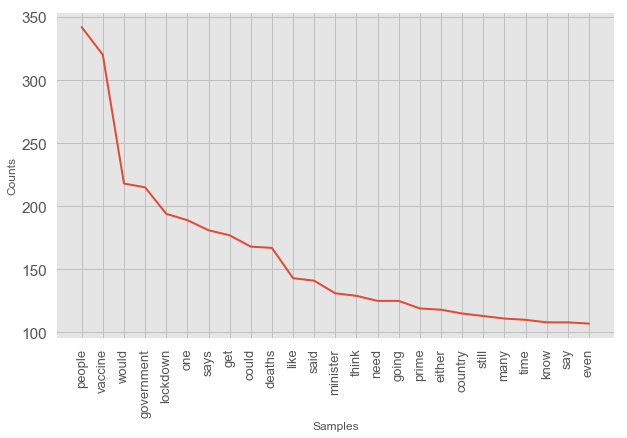

<Figure size 720x432 with 0 Axes>

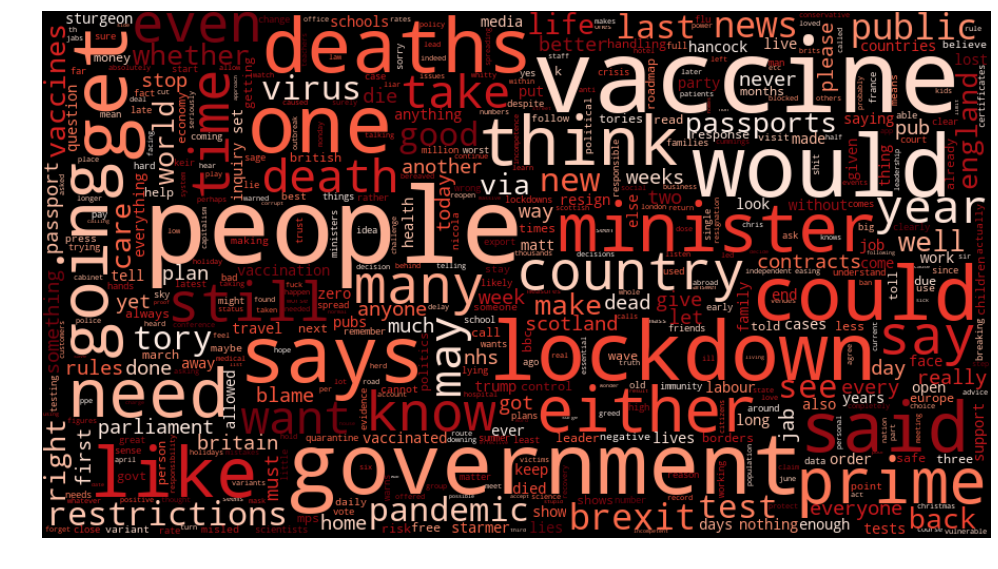

In [200]:
# Data Exploration - Research Data
# general
import os
import pandas as pd
import numpy as np
import csv
import string
import matplotlib.pyplot as plt
import seaborn as sns
import random
import itertools
import collections
from collections import Counter

# tweets
import tweepy as tw
import re
from collections import Counter
from string import punctuation
from tweepy import OAuthHandler
import json

# text manipulation 
import nltk 
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.porter import * 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# plots
from wordcloud import WordCloud
import plotly
import chart_studio.plotly as py
import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
cf.go_offline()

# set plot preferences
plt.style.use(style='ggplot')
plt.rcParams['figure.figsize'] = (10, 6)
pd.set_option("display.max_colwidth", 200) 

# hide warnings
import warnings
warnings.filterwarnings("ignore")

print('Libraries imported')

# df = pd.read_csv('sturgeon_cleaned_with_features.csv')
df = pd.read_csv('boris_cleaned_with_features.csv')

plt.style.use(style='ggplot')
plt.rcParams['figure.figsize'] = (10, 6)

# helper function
# Remove search terms and fluff data for wordcloud and term counts
def remove_words(word_list):
#     remove = ['corona', 'covid','sarscov2','...','"','“','”','\'','…','covid19', 'coronavirus', 'cv19', 'covid-19', 'nicolasturgeon', 'nicola', 'sturgeon']
    remove = ['corona', 'covid','sarscov2','...','"','“','”','\'','…','covid19', 'coronavirus', 'cv19', 'covid-19', 'borisjohnson', 'boris', 'johnson']
    return [w for w in word_list if w not in remove]

# use previously tokenized column and create a column for tokens without key words
from ast import literal_eval
df['tokens'] = df['tokens'].apply(literal_eval)
df['no_keywords'] = df['tokens'].apply(remove_words)

no_keywords = []
for ls in df['no_keywords']:
    words = [w for w in ls]
    for word in words:
        no_keywords.append(word)

# plot word frequency distribution of first few words
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(no_keywords)
fd.plot(25,cumulative=False)

# plt.savefig('Sturgeon_Most_Common_words_nokeywords.png', bbox_inches='tight')
plt.savefig('Boris_Most_Common_words_nokeywords.png', bbox_inches='tight')
plt.show()

# split sentences to get individual words
all_words = []
for line in df['no_keywords']:
    all_words.extend(line)
    
# create a word frequency dictionary
wordfreq = Counter(all_words)

# draw a Word Cloud with word frequencies
wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=500,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='Reds',
                      normalize_plurals=True).generate_from_frequencies(wordfreq)

plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
# plt.savefig('Sturgeon_wordcloud.png', bbox_inches='tight')
plt.savefig('Boris_wordcloud.png', bbox_inches='tight')
plt.show()


In [ ]:
SVM MODEL APPLICATION

Libraries imported
number of positive tagged sentences is:  14943
number of negative tagged sentences is: 15773
total length of the data is:            30716
number of positive tagged sentences is:  10993
number of negative tagged sentences is: 12175
number of neutral tagged sentences is: 7548
total length of the data is:            30716
Lockdown Results
number of positive tagged sentences is:  667
number of negative tagged sentences is: 592
number of neutral tagged sentences is: 449
total length of the data is:            1708
Vaccine Results
number of positive tagged sentences is:  1095
number of negative tagged sentences is: 745
number of neutral tagged sentences is: 555
total length of the data is:            2395
| Term     |   Positive |   Negative |   Neutral |
|----------+------------+------------+-----------|
| lockdown |        667 |        592 |       449 |
| vaccine  |       1095 |        745 |       555 |


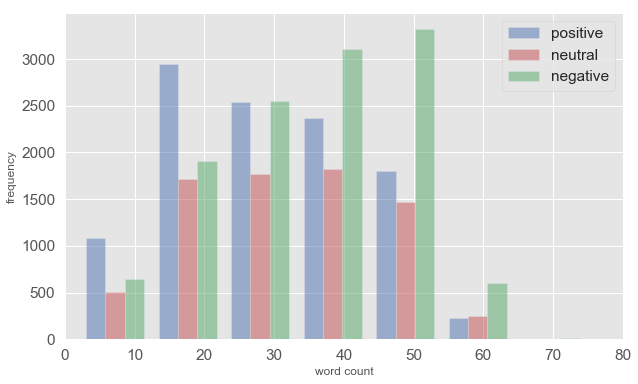

In [273]:
# general
import os
import time
import pandas as pd
import numpy as np
import csv
import string
import matplotlib.pyplot as plt
import seaborn as sns
import random
import itertools
import collections
from collections import Counter
from tabulate import tabulate

# tweets
import tweepy as tw
import re
from collections import Counter
from string import punctuation
from tweepy import OAuthHandler
import json

# text manipulation 
import nltk 
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.porter import * 

# Machine Learning
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

# hide warnings
import warnings
warnings.filterwarnings("ignore")

# set plot preferences
plt.style.use(style='ggplot')
plt.rcParams['figure.figsize'] = (10, 6)
pd.set_option("display.max_colwidth", 200) 

print('Libraries imported')
%matplotlib inline

# Load back in
df = pd.read_csv('sturgeon_cleaned_with_features.csv')
# df = pd.read_csv('boris_cleaned_with_features.csv')

df.dropna(subset=['tidy_tweet'], inplace=True)

# Extracting Features
features = ['tidy_tweet', 'neu_scores', 'neg_scores', 'compound_scores', 'pos_scores']

# Saving features used 
X = df[[col for col in df.columns if col in features]]

# load grid model
svm_grid = joblib.load("trainingandtestdata/train_data_cleaned_feat_eng_lexicon_baselined_model_grid_svm.pkl")

y_preds_svm = svm_grid.predict(X)
y_preds_dec_svm = svm_grid.decision_function(X)

df_tweets = df
# append predictions and confidence to dataframe
df_tweets['predictions'] = y_preds_svm

# check the number of positive vs. negative tagged sentences
positives = df_tweets['predictions'][df_tweets.predictions == 1]
negatives = df_tweets['predictions'][df_tweets.predictions == 0]

print('number of positive tagged sentences is:  {}'.format(len(positives)))
print('number of negative tagged sentences is: {}'.format(len(negatives)))
print('total length of the data is:            {}'.format(df_tweets.shape[0]))

# count neutral based on close confidence scores.
df_tweets['predictions_prob'] = y_preds_dec_svm
df_tweets.loc[(df_tweets['predictions_prob'] > -0.25) & (df_tweets['predictions_prob'] < 0.25), 'predictions'] = 2


# check the number of positive vs. negative tagged sentences
positives = df_tweets['predictions'][df_tweets.predictions == 1]
negatives = df_tweets['predictions'][df_tweets.predictions == 0]
neutral = df_tweets['predictions'][df_tweets.predictions == 2]

print('number of positive tagged sentences is:  {}'.format(len(positives)))
print('number of negative tagged sentences is: {}'.format(len(negatives)))
print('number of neutral tagged sentences is: {}'.format(len(neutral)))
print('total length of the data is:            {}'.format(df_tweets.shape[0]))

df_tweets.head()
# Let’s check out a few positive/negative labelled tweets:
pd.set_option('display.max_colwidth', -1)
df_tweets[df_tweets['predictions'] == 'Neutral'].tail(5) # negative

# plot word count distribution for both positive and negative sentiments
plt.style.use(style='ggplot')
plt.rcParams['figure.figsize'] = (10, 6)
pd.set_option("display.max_colwidth", 400) 

# get a word count per sentence column
def word_count(sentence):
    return len(sentence.split())
    
df_tweets['word count'] = df_tweets['text'].apply(word_count)

x = df_tweets['word count'][df_tweets.predictions == 1]
y = df_tweets['word count'][df_tweets.predictions == 2]
z = df_tweets['word count'][df_tweets.predictions == 0]
plt.xlim(0,80)
plt.xlabel('word count')
plt.ylabel('frequency')
g = plt.hist([x, y, z], color=['b','r','g'], alpha=0.5, label=['positive','neutral','negative'])
plt.legend(loc='upper right');

# Show first instance of positive, negative and neutral labelled tweets
df_tweets.loc[(df_tweets['predictions_prob'] > -0.25) & (df_tweets['predictions_prob'] < 0.25), 'prediction_label'] = 'Neutral'
df_tweets.loc[(df_tweets['predictions_prob'] >= 0.25), 'prediction_label'] = 'Positive'
df_tweets.loc[(df_tweets['predictions_prob'] <= -0.25), 'prediction_label'] = 'Negative'
df_reduced = df_tweets[['text', 'predictions_prob', 'prediction_label']].copy()
df_reduced.head()
df_neutral = df_reduced[df_reduced.prediction_label == "Neutral"].head(1)
df_positive = df_reduced[df_reduced.prediction_label == "Positive"].head(1)
df_negative = df_reduced[df_reduced.prediction_label == "Negative"].head(1)
df_display = pd.concat([df_neutral, df_positive, df_negative])
df_display.head()

# Show results on lockdown
df_lockdown = df_reduced[df_reduced.text.str.contains("lockdown")]
df_lockdown.head()
# check the number of positive vs. negative tagged sentences
lockdown_positives = df_lockdown['prediction_label'][df_lockdown.prediction_label == 'Positive']
lockdown_negatives = df_lockdown['prediction_label'][df_lockdown.prediction_label == 'Negative']
lockdown_neutral = df_lockdown['prediction_label'][df_lockdown.prediction_label == 'Neutral']
print('Lockdown Results')
print('number of positive tagged sentences is:  {}'.format(len(lockdown_positives)))
print('number of negative tagged sentences is: {}'.format(len(lockdown_negatives)))
print('number of neutral tagged sentences is: {}'.format(len(lockdown_neutral)))
print('total length of the data is:            {}'.format(df_lockdown.shape[0]))

# Show results on vaccine
df_vaccine = df_reduced[df_reduced.text.str.contains("vaccine")]
df_vaccine.head()
# check the number of positive vs. negative tagged sentences
vaccine_positives = df_vaccine['prediction_label'][df_vaccine.prediction_label == 'Positive']
vaccine_negatives = df_vaccine['prediction_label'][df_vaccine.prediction_label == 'Negative']
vaccine_neutral = df_vaccine['prediction_label'][df_vaccine.prediction_label == 'Neutral']
print('Vaccine Results')
print('number of positive tagged sentences is:  {}'.format(len(vaccine_positives)))
print('number of negative tagged sentences is: {}'.format(len(vaccine_negatives)))
print('number of neutral tagged sentences is: {}'.format(len(vaccine_neutral)))
print('total length of the data is:            {}'.format(df_vaccine.shape[0]))

# show lockdown and vaccine sentiment
terms_list = ["Term", "Positive", "Negative", "Neutral"]
data = np.array([["lockdown", len(lockdown_positives), len(lockdown_negatives), len(lockdown_neutral)],
                 ["vaccine", len(vaccine_positives), len(vaccine_negatives), len(vaccine_neutral)]])
print(tabulate(data, headers=terms_list, tablefmt='orgtbl'))